# Pipeline to train and evaluate a regularized linear Elastic Net model with no feature selection/dimensionality reduction

Author: Wylie Kau, Last Edit: 2/19/2025

v1

- Added functionality to train, evaluate error on a trained model, and save results for future use.
- Framework should be mutable to different model types/architectures moving forward.

### Imports

In [1]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.random.seed(42)
import pandas as pd
import rdkit
from rdkit.Chem import Draw, Lipinski, Crippen, Descriptors
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
import pubchempy as pcp
import re
from datetime import datetime
import pickle
import os

import sklearn
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

plt.style.use('wfk')

### Helper Function Definition

In [2]:
# Helper functions

def RMSE(y1, y2):
    return np.sqrt(mean_squared_error(y1, y2))

def MSE(y1, y2):
    return mean_squared_error(y1, y2)

def MAPE(y1, y2):
    return mean_absolute_percentage_error(y1, y2)

def SMAPE(y1, y2):
    return 100 * np.mean(np.abs(y1 - y2) / ((np.abs(y1) + np.abs(y2)) / 2))

def iupac_from_smiles(smiles):
    try:
        compound = pcp.get_compounds(smiles, 'smiles')[0]
        return compound.iupac_name
    except:
        return 'N/A'

In [3]:
def eval_model(m, X_train, X_test, y_train, y_test, parity_plot=True):
    
    # train and test predictions
    y_train_pred = m.predict(X_train)
    y_test_pred = m.predict(X_test)

    # train and test RMSE
    rmse_train = RMSE(y_train, y_train_pred)
    rmse_test = RMSE(y_test, y_test_pred)
    
    # train and test R^2
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # train and test SMAPE
    smape_train = SMAPE(y_train, y_train_pred)
    smape_test = SMAPE(y_test, y_test_pred)

    # store results
    results = {'Test': {'RMSE': rmse_test, 'R^2': r2_test, 'SMAPE': smape_test},
               'Train': {'RMSE': rmse_train, 'R^2': r2_train, 'SMAPE': smape_train}}
    results_df = pd.DataFrame(results)

    # plot, if desirable
    if parity_plot:
        fig, axs = plt.subplots(1, figsize=(4,4), dpi=100)

        axs.scatter(y_train, y_train_pred, color='tab:blue', alpha=0.4, label='Train')
        axs.scatter(y_test, y_test_pred, color='tab:orange', alpha=0.7, label='Test')

        max_val = max(max(y_train), max(y_test))
        min_val = min(min(y_train), min(y_test))

        axs.plot((min_val, max_val), [min_val, max_val], color='tab:red',
                 linestyle='--', label='Perfect Prediction')
        
        axs.set_xlabel(r'Observed $\Delta G_{Ion-Ligand}$ [kcal/mol]', fontsize=14)
        axs.set_ylabel(r'Predicted $\Delta G_{Ion-Ligand}$ [kcal/mol]', fontsize=14)
        m_class = m.__class__.__name__
        title_str = f'{m_class}\nTrain: R2 = {r2_train:.2f}, RMSE = {rmse_train:.3f} [kcal/mol], SMAPE = {smape_train:.1f}%\nTest: R2 = {r2_test:.2f}, RMSE = {rmse_test:.3f} [kcal/mol], SMAPE = {smape_test:.1f}%'
        axs.set_title(title_str, fontweight='bold')
        axs.legend(frameon=True, fontsize=10, loc='lower right')

    else:
        fig = None

    return results_df, fig

### 1 - Data Imports

In [4]:
df = pd.read_csv("../Outputs/Featurized NIST46 Dataset for Model Training/AllMolEncodings+set5-2_ion-encodings.csv")

non_features = ['delta_G', 'smiles', 'Electrophile', 'Ligand']
features = [f for f in list(df.columns) if f not in non_features]
target = ['delta_G']

# IF desirable, drop the lanthanides from the electophile set.
# drop_ephiles = ['La3+', 'Pr3+', 'Nd3+', 'Sm3+', 'Gd3+', 'Tb3+', 'Dy3+', 'Er3+']
# df = df[~df['Electrophile'].isin(drop_ephiles)]
# df.reset_index(drop=True, inplace=True)

ephiles = list(df['Electrophile'].unique())
print(ephiles)
print(features)

ligands = list(df['smiles'].unique())
ligand_to_index_map = df.groupby('smiles').apply(lambda x: x.index.tolist()).to_dict()
ephile_to_index_map = df.groupby('Electrophile').apply(lambda x: x.index.tolist()).to_dict()
ephile_to_ligand_map = df.groupby('Electrophile').apply(lambda x: list(x['smiles'].unique())).to_dict()


X = df[features]
X = np.array(X)
y = df[target]
y = np.array(y).ravel()

print(f"{X.shape[1]} Features, {X.shape[0]} Samples")

['Mg2+', 'Ca2+', 'Sr2+', 'La3+', 'Pr3+', 'Nd3+', 'Sm3+', 'Gd3+', 'Tb3+', 'Dy3+', 'Er3+', 'Mn2+', 'Co2+', 'Ni2+', 'Cu2+', 'Al3+', 'Zn2+', 'Na+', 'Fe3+', 'Li+', 'K+', 'Rb+', 'Cs+']
['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR

/var/folders/51/1469qh3n09s2ntzgsg9vcfzc0000gn/T/ipykernel_75341/3567505052.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ligand_to_index_map = df.groupby('smiles').apply(lambda x: x.index.tolist()).to_dict()
/var/folders/51/1469qh3n09s2ntzgsg9vcfzc0000gn/T/ipykernel_75341/3567505052.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ephile_to_index_map = df.groupby('Electrophile').apply(lambda x: 

### 2 - Model Hyperparameter Selection with Cross Validation using HalvingGridSearchCV

In [5]:
# Split data into training and test set with no specified holdout (e.g. ligand or ion specific holdout).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Specify GridSearchCV parameters
en_param_grid = param_grid = {
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0],
    'l1_ratio': np.arange(0, 1, 0.01)
}

n_cv_folds = 3

In [7]:
# Perform GridSearchCV hyperparameter tuning
grid_search = HalvingGridSearchCV(ElasticNet(),
                               param_grid=en_param_grid,
                               cv=n_cv_folds, verbose=3)

grid_search.fit(X_train, y_train)

best_m = grid_search.best_estimator_
best_m_parameters = grid_search.best_params_
print(f"Best LightGBM Model Parameters: {best_m_parameters}")

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 7
max_resources_: 5605
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 800
n_resources: 7
Fitting 3 folds for each of 800 candidates, totalling 2400 fits
[CV 1/3] END alpha=1e-05, l1_ratio=0.0;, score=(train=1.000, test=-54.969) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.0;, score=(train=1.000, test=-14.786) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.0;, score=(train=1.000, test=-85.526) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.01;, score=(train=1.000, test=-51.719) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.01;, score=(train=1.000, test=-14.803) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.01;, score=(train=1.000, test=-97.626) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.02;, score=(train=1.000, test=-48.491) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.02;, score=(train=1.000, test=-14.774) t

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.568e-04, tolerance: 8.529e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.635e-04, tolerance: 8.529e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=1e-05, l1_ratio=0.42;, score=(train=1.000, test=-15.550) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.42;, score=(train=1.000, test=-82.769) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.43;, score=(train=1.000, test=-18.967) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.43;, score=(train=1.000, test=-15.550) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.43;, score=(train=1.000, test=-82.343) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.44;, score=(train=1.000, test=-18.983) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.44;, score=(train=1.000, test=-15.549) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.44;, score=(train=1.000, test=-81.866) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.45;, score=(train=1.000, test=-19.005) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.45;, score=(train=1.000, test=-15.551) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.45;, score=(t

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.014e-03, tolerance: 8.529e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.018e-03, tolerance: 8.529e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=1e-05, l1_ratio=0.67;, score=(train=1.000, test=-13.857) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.67;, score=(train=1.000, test=-54.352) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.68;, score=(train=1.000, test=-20.084) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.68;, score=(train=1.000, test=-13.839) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.68;, score=(train=1.000, test=-52.475) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.6900000000000001;, score=(train=1.000, test=-20.160) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.6900000000000001;, score=(train=1.000, test=-13.824) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.6900000000000001;, score=(train=1.000, test=-50.628) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.7000000000000001;, score=(train=1.000, test=-20.222) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.7000000000000001;, score=(train=1.000, test=-13.809)

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.893e-04, tolerance: 8.529e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.801e-04, tolerance: 8.529e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 1/3] END alpha=1e-05, l1_ratio=0.91;, score=(train=1.000, test=-17.107) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.91;, score=(train=1.000, test=-13.498) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.91;, score=(train=1.000, test=-8.347) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.92;, score=(train=1.000, test=-17.005) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.92;, score=(train=1.000, test=-13.484) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.92;, score=(train=1.000, test=-6.740) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.93;, score=(train=1.000, test=-16.903) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.93;, score=(train=1.000, test=-13.470) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.93;, score=(train=1.000, test=-5.154) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.9400000000000001;, score=(train=1.000, test=-16.799) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.94

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.166e-04, tolerance: 2.145e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.207e-04, tolerance: 2.145e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=0.0001, l1_ratio=0.12;, score=(train=1.000, test=-40.637) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.13;, score=(train=1.000, test=-49.436) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.13;, score=(train=1.000, test=-9.988) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.13;, score=(train=1.000, test=-40.822) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.14;, score=(train=1.000, test=-48.810) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.14;, score=(train=1.000, test=-9.455) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.14;, score=(train=1.000, test=-41.012) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.15;, score=(train=1.000, test=-48.046) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.15;, score=(train=1.000, test=-8.963) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.15;, score=(train=1.000, test=-41.205) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.16;, 

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.956e-04, tolerance: 2.145e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.981e-04, tolerance: 2.145e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=0.0001, l1_ratio=0.36;, score=(train=1.000, test=-5.602) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.36;, score=(train=1.000, test=-44.745) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.37;, score=(train=1.000, test=-19.145) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.37;, score=(train=1.000, test=-5.529) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.37;, score=(train=1.000, test=-44.891) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.38;, score=(train=1.000, test=-18.882) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.38;, score=(train=1.000, test=-5.456) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.38;, score=(train=1.000, test=-45.037) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.39;, score=(train=1.000, test=-18.704) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.39;, score=(train=1.000, test=-5.382) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.39;, s

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.242e-04, tolerance: 2.145e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.265e-04, tolerance: 2.145e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 1/3] END alpha=0.0001, l1_ratio=0.5700000000000001;, score=(train=1.000, test=-32.863) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.5700000000000001;, score=(train=1.000, test=-4.063) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.5700000000000001;, score=(train=1.000, test=-47.509) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.58;, score=(train=1.000, test=-36.683) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.58;, score=(train=1.000, test=-3.989) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.58;, score=(train=1.000, test=-47.600) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.59;, score=(train=1.000, test=-40.661) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.59;, score=(train=1.000, test=-3.915) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.59;, score=(train=1.000, test=-47.674) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.6;, score=(train=1.000, test=-44.873) total time=   0.0s
[C

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.812e-04, tolerance: 2.145e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.826e-04, tolerance: 2.145e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 1/3] END alpha=0.0001, l1_ratio=0.8200000000000001;, score=(train=1.000, test=-89.693) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.8200000000000001;, score=(train=1.000, test=-3.700) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.8200000000000001;, score=(train=1.000, test=-49.173) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.8300000000000001;, score=(train=1.000, test=-91.620) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.8300000000000001;, score=(train=1.000, test=-3.710) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.8300000000000001;, score=(train=1.000, test=-49.216) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.84;, score=(train=1.000, test=-93.806) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.84;, score=(train=1.000, test=-3.693) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.84;, score=(train=1.000, test=-49.269) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.85;, score=(train

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.223e-04, tolerance: 2.145e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.178e-04, tolerance: 9.590e-05
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=0.001, l1_ratio=0.06;, score=(train=1.000, test=-63.431) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.07;, score=(train=1.000, test=-505.809) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.07;, score=(train=1.000, test=-1.571) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.07;, score=(train=1.000, test=-64.690) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.08;, score=(train=1.000, test=-312.955) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.08;, score=(train=1.000, test=-1.498) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.08;, score=(train=1.000, test=-65.722) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.09;, score=(train=1.000, test=-161.704) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.09;, score=(train=1.000, test=-1.374) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.09;, score=(train=1.000, test=-66.780) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.1;, score=(tr

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.167e-04, tolerance: 2.145e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.760e-04, tolerance: 9.590e-05
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=0.001, l1_ratio=0.33;, score=(train=1.000, test=-77.766) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.34;, score=(train=1.000, test=-0.154) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.34;, score=(train=1.000, test=-0.010) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.34;, score=(train=1.000, test=-78.196) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.35000000000000003;, score=(train=1.000, test=-0.133) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.35000000000000003;, score=(train=1.000, test=0.041) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.35000000000000003;, score=(train=1.000, test=-78.635) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.36;, score=(train=1.000, test=-0.067) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.36;, score=(train=1.000, test=0.092) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.36;, score=(train=1.000, test=-79.078) total time=   0.0s
[CV 1/3] END 

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.400e-03, tolerance: 8.529e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.462e-04, tolerance: 2.145e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=0.001, l1_ratio=0.63;, score=(train=1.000, test=0.950) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.63;, score=(train=1.000, test=-96.142) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.64;, score=(train=1.000, test=0.857) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.64;, score=(train=1.000, test=0.946) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.64;, score=(train=1.000, test=-96.911) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.65;, score=(train=1.000, test=0.866) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.65;, score=(train=1.000, test=0.941) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.65;, score=(train=1.000, test=-97.698) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.66;, score=(train=1.000, test=0.873) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.66;, score=(train=1.000, test=0.936) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.66;, score=(train=1.000, te

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.538e-03, tolerance: 8.529e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.605e-04, tolerance: 2.145e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 1/3] END alpha=0.001, l1_ratio=0.9400000000000001;, score=(train=1.000, test=0.528) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.9400000000000001;, score=(train=1.000, test=0.557) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.9400000000000001;, score=(train=1.000, test=-122.537) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.9500000000000001;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.9500000000000001;, score=(train=1.000, test=0.534) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.9500000000000001;, score=(train=1.000, test=-123.407) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.96;, score=(train=1.000, test=0.474) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.96;, score=(train=1.000, test=0.510) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.96;, score=(train=1.000, test=-124.369) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.97;, score=(train=1.000, test=0.4

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.491e-03, tolerance: 8.529e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.902e-04, tolerance: 2.145e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 1/3] END alpha=0.01, l1_ratio=0.18;, score=(train=1.000, test=-8.056) total time=   0.0s
[CV 2/3] END alpha=0.01, l1_ratio=0.18;, score=(train=1.000, test=0.873) total time=   0.0s
[CV 3/3] END alpha=0.01, l1_ratio=0.18;, score=(train=1.000, test=-182.931) total time=   0.0s
[CV 1/3] END alpha=0.01, l1_ratio=0.19;, score=(train=1.000, test=-9.946) total time=   0.0s
[CV 2/3] END alpha=0.01, l1_ratio=0.19;, score=(train=1.000, test=0.818) total time=   0.0s
[CV 3/3] END alpha=0.01, l1_ratio=0.19;, score=(train=1.000, test=-182.305) total time=   0.0s
[CV 1/3] END alpha=0.01, l1_ratio=0.2;, score=(train=1.000, test=-12.042) total time=   0.0s
[CV 2/3] END alpha=0.01, l1_ratio=0.2;, score=(train=1.000, test=0.776) total time=   0.0s
[CV 3/3] END alpha=0.01, l1_ratio=0.2;, score=(train=1.000, test=-181.705) total time=   0.0s
[CV 1/3] END alpha=0.01, l1_ratio=0.21;, score=(train=1.000, test=-14.102) total time=   0.0s
[CV 2/3] END alpha=0.01, l1_ratio=0.21;, score=(train=1.000, test=0.

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.607e-04, tolerance: 9.590e-05
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.309e-03, tolerance: 8.529e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=0.01, l1_ratio=0.5;, score=(train=1.000, test=-180.442) total time=   0.0s
[CV 1/3] END alpha=0.01, l1_ratio=0.51;, score=(train=1.000, test=-53.225) total time=   0.0s
[CV 2/3] END alpha=0.01, l1_ratio=0.51;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 3/3] END alpha=0.01, l1_ratio=0.51;, score=(train=1.000, test=-180.960) total time=   0.0s
[CV 1/3] END alpha=0.01, l1_ratio=0.52;, score=(train=1.000, test=-53.489) total time=   0.0s
[CV 2/3] END alpha=0.01, l1_ratio=0.52;, score=(train=1.000, test=-0.010) total time=   0.0s
[CV 3/3] END alpha=0.01, l1_ratio=0.52;, score=(train=1.000, test=-181.228) total time=   0.0s
[CV 1/3] END alpha=0.01, l1_ratio=0.53;, score=(train=1.000, test=-53.726) total time=   0.0s
[CV 2/3] END alpha=0.01, l1_ratio=0.53;, score=(train=1.000, test=-0.021) total time=   0.0s
[CV 3/3] END alpha=0.01, l1_ratio=0.53;, score=(train=1.000, test=-181.543) total time=   0.0s
[CV 1/3] END alpha=0.01, l1_ratio=0.54;, score=(train=1.000, 

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.628e-03, tolerance: 8.529e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.046e-03, tolerance: 2.145e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=0.01, l1_ratio=0.86;, score=(train=1.000, test=-202.899) total time=   0.0s
[CV 1/3] END alpha=0.01, l1_ratio=0.87;, score=(train=1.000, test=-63.087) total time=   0.0s
[CV 2/3] END alpha=0.01, l1_ratio=0.87;, score=(train=1.000, test=-0.045) total time=   0.0s
[CV 3/3] END alpha=0.01, l1_ratio=0.87;, score=(train=1.000, test=-203.595) total time=   0.0s
[CV 1/3] END alpha=0.01, l1_ratio=0.88;, score=(train=1.000, test=-63.215) total time=   0.0s
[CV 2/3] END alpha=0.01, l1_ratio=0.88;, score=(train=1.000, test=-0.045) total time=   0.0s
[CV 3/3] END alpha=0.01, l1_ratio=0.88;, score=(train=1.000, test=-204.256) total time=   0.0s
[CV 1/3] END alpha=0.01, l1_ratio=0.89;, score=(train=1.000, test=-63.322) total time=   0.0s
[CV 2/3] END alpha=0.01, l1_ratio=0.89;, score=(train=1.000, test=-0.045) total time=   0.0s
[CV 3/3] END alpha=0.01, l1_ratio=0.89;, score=(train=1.000, test=-204.952) total time=   0.0s
[CV 1/3] END alpha=0.01, l1_ratio=0.9;, score=(train=1.000,

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.294e-04, tolerance: 2.145e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.332e-03, tolerance: 8.529e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 1/3] END alpha=0.1, l1_ratio=0.23;, score=(train=1.000, test=-56.678) total time=   0.0s
[CV 2/3] END alpha=0.1, l1_ratio=0.23;, score=(train=1.000, test=-0.035) total time=   0.0s
[CV 3/3] END alpha=0.1, l1_ratio=0.23;, score=(train=1.000, test=-351.220) total time=   0.0s
[CV 1/3] END alpha=0.1, l1_ratio=0.24;, score=(train=1.000, test=-55.930) total time=   0.0s
[CV 2/3] END alpha=0.1, l1_ratio=0.24;, score=(train=1.000, test=-0.034) total time=   0.0s
[CV 3/3] END alpha=0.1, l1_ratio=0.24;, score=(train=1.000, test=-353.134) total time=   0.0s
[CV 1/3] END alpha=0.1, l1_ratio=0.25;, score=(train=1.000, test=-55.164) total time=   0.0s
[CV 2/3] END alpha=0.1, l1_ratio=0.25;, score=(train=1.000, test=-0.034) total time=   0.0s
[CV 3/3] END alpha=0.1, l1_ratio=0.25;, score=(train=1.000, test=-355.041) total time=   0.0s
[CV 1/3] END alpha=0.1, l1_ratio=0.26;, score=(train=1.000, test=-54.428) total time=   0.0s
[CV 2/3] END alpha=0.1, l1_ratio=0.26;, score=(train=1.000, test=-0.03

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.187e-04, tolerance: 2.145e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.032e-04, tolerance: 2.145e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=1.0, l1_ratio=0.25;, score=(train=0.999, test=0.094) total time=   0.0s
[CV 3/3] END alpha=1.0, l1_ratio=0.25;, score=(train=1.000, test=-358.388) total time=   0.0s
[CV 1/3] END alpha=1.0, l1_ratio=0.26;, score=(train=0.998, test=-61.942) total time=   0.0s
[CV 2/3] END alpha=1.0, l1_ratio=0.26;, score=(train=0.999, test=0.100) total time=   0.0s
[CV 3/3] END alpha=1.0, l1_ratio=0.26;, score=(train=1.000, test=-358.224) total time=   0.0s
[CV 1/3] END alpha=1.0, l1_ratio=0.27;, score=(train=0.997, test=-61.932) total time=   0.0s
[CV 2/3] END alpha=1.0, l1_ratio=0.27;, score=(train=0.999, test=0.105) total time=   0.0s
[CV 3/3] END alpha=1.0, l1_ratio=0.27;, score=(train=1.000, test=-358.060) total time=   0.0s
[CV 1/3] END alpha=1.0, l1_ratio=0.28;, score=(train=0.997, test=-61.922) total time=   0.0s
[CV 2/3] END alpha=1.0, l1_ratio=0.28;, score=(train=0.999, test=0.111) total time=   0.0s
[CV 3/3] END alpha=1.0, l1_ratio=0.28;, score=(train=1.000, test=-357.896) 

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.898e-03, tolerance: 2.145e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.443e-03, tolerance: 9.590e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

[CV 1/3] END alpha=10.0, l1_ratio=0.61;, score=(train=0.888, test=-6.289) total time=   0.0s
[CV 2/3] END alpha=10.0, l1_ratio=0.61;, score=(train=0.929, test=-0.205) total time=   0.0s
[CV 3/3] END alpha=10.0, l1_ratio=0.61;, score=(train=0.990, test=-266.114) total time=   0.0s
[CV 1/3] END alpha=10.0, l1_ratio=0.62;, score=(train=0.885, test=-5.816) total time=   0.0s
[CV 2/3] END alpha=10.0, l1_ratio=0.62;, score=(train=0.927, test=-0.216) total time=   0.0s
[CV 3/3] END alpha=10.0, l1_ratio=0.62;, score=(train=0.990, test=-264.709) total time=   0.0s
[CV 1/3] END alpha=10.0, l1_ratio=0.63;, score=(train=0.881, test=-5.359) total time=   0.0s
[CV 2/3] END alpha=10.0, l1_ratio=0.63;, score=(train=0.925, test=-0.228) total time=   0.0s
[CV 3/3] END alpha=10.0, l1_ratio=0.63;, score=(train=0.989, test=-263.306) total time=   0.0s
[CV 1/3] END alpha=10.0, l1_ratio=0.64;, score=(train=0.877, test=-4.918) total time=   0.0s
[CV 2/3] END alpha=10.0, l1_ratio=0.64;, score=(train=0.922, tes

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.262e-02, tolerance: 2.145e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.389e-02, tolerance: 9.590e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

[CV 3/3] END alpha=100.0, l1_ratio=0.46;, score=(train=0.653, test=-17.767) total time=   0.0s
[CV 1/3] END alpha=100.0, l1_ratio=0.47000000000000003;, score=(train=0.691, test=-0.192) total time=   0.0s
[CV 2/3] END alpha=100.0, l1_ratio=0.47000000000000003;, score=(train=0.241, test=-2.969) total time=   0.0s
[CV 3/3] END alpha=100.0, l1_ratio=0.47000000000000003;, score=(train=0.652, test=-17.708) total time=   0.0s
[CV 1/3] END alpha=100.0, l1_ratio=0.48;, score=(train=0.691, test=-0.193) total time=   0.0s
[CV 2/3] END alpha=100.0, l1_ratio=0.48;, score=(train=0.239, test=-2.965) total time=   0.0s
[CV 3/3] END alpha=100.0, l1_ratio=0.48;, score=(train=0.651, test=-17.649) total time=   0.0s
[CV 1/3] END alpha=100.0, l1_ratio=0.49;, score=(train=0.691, test=-0.193) total time=   0.0s
[CV 2/3] END alpha=100.0, l1_ratio=0.49;, score=(train=0.236, test=-2.961) total time=   0.0s
[CV 3/3] END alpha=100.0, l1_ratio=0.49;, score=(train=0.651, test=-17.590) total time=   0.0s
[CV 1/3] EN

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.539e-03, tolerance: 2.191e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.748e-03, tolerance: 3.639e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 1/3] END alpha=100.0, l1_ratio=0.19;, score=(train=0.346, test=-797.641) total time=   0.0s
[CV 2/3] END alpha=100.0, l1_ratio=0.19;, score=(train=0.220, test=-377.025) total time=   0.0s
[CV 3/3] END alpha=100.0, l1_ratio=0.19;, score=(train=0.560, test=-0.867) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.8200000000000001;, score=(train=1.000, test=0.386) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.8200000000000001;, score=(train=1.000, test=-38.010) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.8200000000000001;, score=(train=1.000, test=-4.848) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.52;, score=(train=1.000, test=-7.575) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.52;, score=(train=1.000, test=-3.835) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.52;, score=(train=1.000, test=-5.825) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.81;, score=(train=1.000, test=0.438) total time=   0.0s
[CV 2/3] END al

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.329e-04, tolerance: 4.812e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.427e-03, tolerance: 2.191e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=0.0001, l1_ratio=0.63;, score=(train=1.000, test=-7.058) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.63;, score=(train=1.000, test=-7.647) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.75;, score=(train=1.000, test=0.522) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.75;, score=(train=1.000, test=-43.463) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.75;, score=(train=1.000, test=-5.170) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.5700000000000001;, score=(train=1.000, test=-7.497) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.5700000000000001;, score=(train=1.000, test=-3.684) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.5700000000000001;, score=(train=1.000, test=-5.799) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.74;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.74;, score=(train=1.000, test=-44.259) total time=   0.0s
[CV 3/3] END alp

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.259e-03, tolerance: 3.639e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.199e-03, tolerance: 4.812e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=0.001, l1_ratio=0.7000000000000001;, score=(train=1.000, test=-5.448) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.6;, score=(train=1.000, test=-7.402) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.6;, score=(train=1.000, test=-3.597) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.6;, score=(train=1.000, test=-5.785) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.61;, score=(train=1.000, test=-63.124) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.61;, score=(train=1.000, test=-6.157) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.61;, score=(train=1.000, test=-7.688) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.14;, score=(train=1.000, test=-5.682) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.14;, score=(train=1.000, test=-3.592) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.14;, score=(train=1.000, test=-11.697) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.11;

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.918e-04, tolerance: 4.812e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e-03, tolerance: 2.191e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=0.001, l1_ratio=0.66;, score=(train=1.000, test=-50.964) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.66;, score=(train=1.000, test=-5.690) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.08;, score=(train=1.000, test=-4.970) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.08;, score=(train=1.000, test=-2.355) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.08;, score=(train=1.000, test=-12.361) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.62;, score=(train=1.000, test=-7.318) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.62;, score=(train=1.000, test=-3.554) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.62;, score=(train=1.000, test=-5.779) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.6;, score=(train=1.000, test=-61.283) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.6;, score=(train=1.000, test=-5.738) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.6;, score=(train

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.945e-03, tolerance: 3.639e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.048e-03, tolerance: 4.812e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 1/3] END alpha=1e-05, l1_ratio=0.64;, score=(train=1.000, test=-7.236) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.64;, score=(train=1.000, test=-3.511) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.64;, score=(train=1.000, test=-5.774) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.21;, score=(train=1.000, test=-9.779) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.21;, score=(train=1.000, test=-2.866) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.21;, score=(train=1.000, test=-10.732) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.61;, score=(train=1.000, test=-0.662) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.61;, score=(train=1.000, test=-54.587) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.61;, score=(train=1.000, test=-6.027) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.59;, score=(train=1.000, test=-59.496) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.59;, score=(tra

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.160e-04, tolerance: 4.812e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.109e-03, tolerance: 2.191e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=0.001, l1_ratio=0.56;, score=(train=1.000, test=-6.380) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.24;, score=(train=1.000, test=-10.732) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.24;, score=(train=1.000, test=-2.643) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.24;, score=(train=1.000, test=-10.294) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.58;, score=(train=1.000, test=-57.643) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.58;, score=(train=1.000, test=-4.888) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.58;, score=(train=1.000, test=-7.752) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.67;, score=(train=1.000, test=-7.133) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.67;, score=(train=1.000, test=-3.448) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.67;, score=(train=1.000, test=-5.767) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.55;, score=(tr

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.301e-04, tolerance: 4.812e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.095e-04, tolerance: 2.191e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=0.001, l1_ratio=0.49;, score=(train=1.000, test=-59.908) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.49;, score=(train=1.000, test=-6.918) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.48;, score=(train=1.000, test=-3.407) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.48;, score=(train=1.000, test=-60.336) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.48;, score=(train=1.000, test=-7.000) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.27;, score=(train=1.000, test=-13.166) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.27;, score=(train=1.000, test=-2.513) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.27;, score=(train=1.000, test=-9.991) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.47000000000000003;, score=(train=1.000, test=-3.705) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.47000000000000003;, score=(train=1.000, test=-60.769) total time=   0.0s
[CV 3/3] END alpha=0.00

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.395e-04, tolerance: 4.812e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.427e-04, tolerance: 2.191e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=100.0, l1_ratio=0.23;, score=(train=0.208, test=-405.890) total time=   0.0s
[CV 3/3] END alpha=100.0, l1_ratio=0.23;, score=(train=0.547, test=-0.926) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.39;, score=(train=1.000, test=-6.722) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.39;, score=(train=1.000, test=-58.799) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.39;, score=(train=1.000, test=-7.449) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.38;, score=(train=1.000, test=-7.173) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.38;, score=(train=1.000, test=-57.853) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.38;, score=(train=1.000, test=-7.452) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.37;, score=(train=1.000, test=-7.761) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.37;, score=(train=1.000, test=-56.952) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.37;, score=(train=

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.487e-04, tolerance: 4.812e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.932e-04, tolerance: 2.191e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=0.001, l1_ratio=0.22;, score=(train=1.000, test=-52.805) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.22;, score=(train=1.000, test=-7.977) total time=   0.0s
[CV 1/3] END alpha=100.0, l1_ratio=0.24;, score=(train=0.346, test=-794.947) total time=   0.0s
[CV 2/3] END alpha=100.0, l1_ratio=0.24;, score=(train=0.204, test=-413.273) total time=   0.0s
[CV 3/3] END alpha=100.0, l1_ratio=0.24;, score=(train=0.543, test=-0.941) total time=   0.0s
[CV 1/3] END alpha=0.001, l1_ratio=0.21;, score=(train=1.000, test=-23.933) total time=   0.0s
[CV 2/3] END alpha=0.001, l1_ratio=0.21;, score=(train=1.000, test=-52.859) total time=   0.0s
[CV 3/3] END alpha=0.001, l1_ratio=0.21;, score=(train=1.000, test=-7.979) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.33;, score=(train=1.000, test=-18.482) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.33;, score=(train=1.000, test=-2.382) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.33;, score=(

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.579e-04, tolerance: 2.191e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.125e-03, tolerance: 3.639e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=0.001, l1_ratio=0.12;, score=(train=1.000, test=-7.677) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.35000000000000003;, score=(train=1.000, test=-20.932) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.35000000000000003;, score=(train=1.000, test=-2.401) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.35000000000000003;, score=(train=1.000, test=-9.288) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.76;, score=(train=1.000, test=-6.955) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.76;, score=(train=1.000, test=-3.270) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.76;, score=(train=1.000, test=-5.753) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.36;, score=(train=1.000, test=-22.305) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.36;, score=(train=1.000, test=-2.348) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.36;, score=(train=1.000, test=-9.212) total time=   0.0s
[CV 1/3

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.253e-04, tolerance: 3.639e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.118e-04, tolerance: 2.191e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=0.0001, l1_ratio=0.48;, score=(train=1.000, test=-2.348) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.48;, score=(train=1.000, test=-8.224) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.39;, score=(train=1.000, test=-26.692) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.39;, score=(train=1.000, test=-2.243) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.39;, score=(train=1.000, test=-8.970) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.49;, score=(train=1.000, test=-42.266) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.49;, score=(train=1.000, test=-2.464) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.49;, score=(train=1.000, test=-8.145) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.5;, score=(train=1.000, test=-44.093) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.5;, score=(train=1.000, test=-2.609) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.5;, score=(

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.092e-04, tolerance: 2.191e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.949e-04, tolerance: 3.639e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=1e-05, l1_ratio=0.8300000000000001;, score=(train=1.000, test=-5.749) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.84;, score=(train=1.000, test=-6.791) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.84;, score=(train=1.000, test=-3.126) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.84;, score=(train=1.000, test=-5.748) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.85;, score=(train=1.000, test=-6.770) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.85;, score=(train=1.000, test=-3.108) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.85;, score=(train=1.000, test=-5.747) total time=   0.0s
[CV 1/3] END alpha=100.0, l1_ratio=0.28;, score=(train=0.346, test=-792.795) total time=   0.0s
[CV 2/3] END alpha=100.0, l1_ratio=0.28;, score=(train=0.189, test=-443.475) total time=   0.0s
[CV 3/3] END alpha=100.0, l1_ratio=0.28;, score=(train=0.527, test=-1.006) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.86;, 

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.230e-04, tolerance: 2.191e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.020e-04, tolerance: 4.812e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=1e-05, l1_ratio=0.93;, score=(train=1.000, test=-5.740) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.9400000000000001;, score=(train=1.000, test=-6.402) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.9400000000000001;, score=(train=1.000, test=-2.951) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.9400000000000001;, score=(train=1.000, test=-5.739) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.99;, score=(train=1.000, test=-6.173) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.99;, score=(train=1.000, test=-2.866) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.99;, score=(train=1.000, test=-5.735) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.98;, score=(train=1.000, test=-6.218) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.98;, score=(train=1.000, test=-2.882) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.98;, score=(train=1.000, test=-5.735) total time=   0.0s
[CV 1/3] END alpha

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.547e-04, tolerance: 4.812e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.353e-04, tolerance: 2.191e-04
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=100.0, l1_ratio=0.78;, score=(train=0.111, test=-562.170) total time=   0.0s
[CV 3/3] END alpha=100.0, l1_ratio=0.78;, score=(train=0.514, test=-1.057) total time=   0.0s
[CV 1/3] END alpha=100.0, l1_ratio=0.79;, score=(train=0.345, test=-765.613) total time=   0.0s
[CV 2/3] END alpha=100.0, l1_ratio=0.79;, score=(train=0.111, test=-561.958) total time=   0.0s
[CV 3/3] END alpha=100.0, l1_ratio=0.79;, score=(train=0.514, test=-1.057) total time=   0.0s
[CV 1/3] END alpha=100.0, l1_ratio=0.8;, score=(train=0.345, test=-765.085) total time=   0.0s
[CV 2/3] END alpha=100.0, l1_ratio=0.8;, score=(train=0.111, test=-561.746) total time=   0.0s
[CV 3/3] END alpha=100.0, l1_ratio=0.8;, score=(train=0.514, test=-1.057) total time=   0.0s
[CV 1/3] END alpha=100.0, l1_ratio=0.81;, score=(train=0.345, test=-764.557) total time=   0.0s
[CV 2/3] END alpha=100.0, l1_ratio=0.81;, score=(train=0.111, test=-561.534) total time=   0.0s
[CV 3/3] END alpha=100.0, l1_ratio=0.81;, score=(

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.761e-02, tolerance: 1.206e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.497e-02, tolerance: 1.344e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=0.0001, l1_ratio=0.39;, score=(train=1.000, test=-4.253) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.38;, score=(train=1.000, test=-0.594) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.38;, score=(train=1.000, test=-1.882) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.38;, score=(train=1.000, test=-4.200) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.37;, score=(train=1.000, test=-0.603) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.37;, score=(train=1.000, test=-1.873) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.37;, score=(train=1.000, test=-4.146) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.36;, score=(train=1.000, test=-0.612) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.36;, score=(train=1.000, test=-1.866) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.36;, score=(train=1.000, test=-4.087) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.350000000000

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.163e-03, tolerance: 1.289e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.908e-03, tolerance: 1.206e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=0.0001, l1_ratio=0.33;, score=(train=1.000, test=-3.830) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.32;, score=(train=1.000, test=-0.645) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.32;, score=(train=1.000, test=-1.808) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.32;, score=(train=1.000, test=-3.765) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.31;, score=(train=1.000, test=-0.652) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.31;, score=(train=1.000, test=-1.791) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.31;, score=(train=1.000, test=-3.712) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.3;, score=(train=1.000, test=-0.659) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.3;, score=(train=1.000, test=-1.775) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.3;, score=(train=1.000, test=-3.665) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.29;, score=(tra

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.799e-03, tolerance: 1.289e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.572e-03, tolerance: 1.206e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=0.0001, l1_ratio=0.26;, score=(train=1.000, test=-3.482) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.25;, score=(train=1.000, test=-0.687) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.25;, score=(train=1.000, test=-1.690) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.25;, score=(train=1.000, test=-3.433) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.24;, score=(train=1.000, test=-0.685) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.24;, score=(train=1.000, test=-1.676) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.24;, score=(train=1.000, test=-3.394) total time=   0.1s
[CV 1/3] END alpha=0.0001, l1_ratio=0.23;, score=(train=1.000, test=-0.682) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.23;, score=(train=1.000, test=-1.662) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.23;, score=(train=1.000, test=-3.368) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.22;, score=(

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.811e-03, tolerance: 1.344e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.337e-03, tolerance: 1.289e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=0.0001, l1_ratio=0.2;, score=(train=1.000, test=-1.619) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.2;, score=(train=1.000, test=-3.218) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.19;, score=(train=1.000, test=-0.661) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.19;, score=(train=1.000, test=-1.603) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.19;, score=(train=1.000, test=-3.166) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.18;, score=(train=1.000, test=-0.658) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.18;, score=(train=1.000, test=-1.591) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.18;, score=(train=1.000, test=-3.116) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.17;, score=(train=1.000, test=-0.656) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.17;, score=(train=1.000, test=-1.580) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.17;, score=(tr

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.114e-03, tolerance: 1.344e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.895e-03, tolerance: 1.289e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=0.0001, l1_ratio=0.13;, score=(train=1.000, test=-1.533) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.13;, score=(train=1.000, test=-2.855) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.12;, score=(train=1.000, test=-0.633) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.12;, score=(train=1.000, test=-1.519) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.12;, score=(train=1.000, test=-2.800) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.11;, score=(train=1.000, test=-0.625) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.11;, score=(train=1.000, test=-1.497) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.11;, score=(train=1.000, test=-2.740) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.1;, score=(train=1.000, test=-0.616) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.1;, score=(train=1.000, test=-1.471) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.1;, score=(tra

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.207e-03, tolerance: 1.206e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.184e-03, tolerance: 1.344e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 1/3] END alpha=0.0001, l1_ratio=0.06;, score=(train=1.000, test=-0.558) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.06;, score=(train=1.000, test=-1.366) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.06;, score=(train=1.000, test=-2.378) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.5;, score=(train=1.000, test=-0.300) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.5;, score=(train=1.000, test=-2.016) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.5;, score=(train=1.000, test=-1.836) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.51;, score=(train=1.000, test=-0.296) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.51;, score=(train=1.000, test=-2.018) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.51;, score=(train=1.000, test=-1.864) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.52;, score=(train=1.000, test=-0.293) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.52;, score=(train=1.000

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.740e-03, tolerance: 1.206e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.831e-03, tolerance: 1.344e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 1/3] END alpha=1e-05, l1_ratio=0.55;, score=(train=1.000, test=-0.283) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.55;, score=(train=1.000, test=-2.022) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.55;, score=(train=1.000, test=-1.978) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.56;, score=(train=1.000, test=-0.279) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.56;, score=(train=1.000, test=-2.021) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.56;, score=(train=1.000, test=-2.006) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.5700000000000001;, score=(train=1.000, test=-0.276) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.5700000000000001;, score=(train=1.000, test=-2.019) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.5700000000000001;, score=(train=1.000, test=-2.035) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.58;, score=(train=1.000, test=-0.272) total time=   0.0s
[CV 2/3] END alpha

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.681e-03, tolerance: 1.289e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.866e-03, tolerance: 1.206e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=1e-05, l1_ratio=0.61;, score=(train=1.000, test=-2.150) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.62;, score=(train=1.000, test=-0.258) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.62;, score=(train=1.000, test=-2.011) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.62;, score=(train=1.000, test=-2.180) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.63;, score=(train=1.000, test=-0.255) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.63;, score=(train=1.000, test=-2.010) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.63;, score=(train=1.000, test=-2.209) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.64;, score=(train=1.000, test=-0.251) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.64;, score=(train=1.000, test=-2.008) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.64;, score=(train=1.000, test=-2.240) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.65;, score=(train=1.000

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e-03, tolerance: 1.344e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e-03, tolerance: 1.289e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=1e-05, l1_ratio=0.67;, score=(train=1.000, test=-2.003) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.67;, score=(train=1.000, test=-2.331) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.68;, score=(train=1.000, test=-0.238) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.68;, score=(train=1.000, test=-2.001) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.68;, score=(train=1.000, test=-2.362) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.6900000000000001;, score=(train=1.000, test=-0.234) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.6900000000000001;, score=(train=1.000, test=-2.000) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.6900000000000001;, score=(train=1.000, test=-2.394) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.7000000000000001;, score=(train=1.000, test=-0.230) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.7000000000000001;, score=(train=1.000, test=-1.999) total tim

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.067e-03, tolerance: 1.206e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.254e-03, tolerance: 1.344e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=1e-05, l1_ratio=0.74;, score=(train=1.000, test=-1.992) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.74;, score=(train=1.000, test=-2.551) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.75;, score=(train=1.000, test=-0.212) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.75;, score=(train=1.000, test=-1.990) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.75;, score=(train=1.000, test=-2.583) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.76;, score=(train=1.000, test=-0.209) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.76;, score=(train=1.000, test=-1.988) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.76;, score=(train=1.000, test=-2.615) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.77;, score=(train=1.000, test=-0.207) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.77;, score=(train=1.000, test=-1.986) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.77;, score=(train=1.000

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.176e-03, tolerance: 1.206e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.402e-03, tolerance: 1.344e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=1e-05, l1_ratio=0.81;, score=(train=1.000, test=-1.979) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.81;, score=(train=1.000, test=-2.749) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.8200000000000001;, score=(train=1.000, test=-0.194) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.8200000000000001;, score=(train=1.000, test=-1.977) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.8200000000000001;, score=(train=1.000, test=-2.769) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.8300000000000001;, score=(train=1.000, test=-0.192) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.8300000000000001;, score=(train=1.000, test=-1.975) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.8300000000000001;, score=(train=1.000, test=-2.789) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.84;, score=(train=1.000, test=-0.189) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.84;, score=(train=1.000, test=-1.

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e-03, tolerance: 1.289e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.268e-03, tolerance: 1.206e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 1/3] END alpha=1e-05, l1_ratio=0.87;, score=(train=1.000, test=-0.182) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.87;, score=(train=1.000, test=-1.968) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.87;, score=(train=1.000, test=-2.869) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.88;, score=(train=1.000, test=-0.180) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.88;, score=(train=1.000, test=-1.966) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.88;, score=(train=1.000, test=-2.889) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.89;, score=(train=1.000, test=-0.178) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.89;, score=(train=1.000, test=-1.964) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.89;, score=(train=1.000, test=-2.909) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.9;, score=(train=1.000, test=-0.175) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.9;, score=(train=1.000, 

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.643e-03, tolerance: 1.344e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.211e-03, tolerance: 1.289e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=1e-05, l1_ratio=0.93;, score=(train=1.000, test=-3.003) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.9400000000000001;, score=(train=1.000, test=-0.170) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.9400000000000001;, score=(train=1.000, test=-1.955) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.9400000000000001;, score=(train=1.000, test=-3.027) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.9500000000000001;, score=(train=1.000, test=-0.170) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.9500000000000001;, score=(train=1.000, test=-1.953) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.9500000000000001;, score=(train=1.000, test=-3.051) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.96;, score=(train=1.000, test=-0.171) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.96;, score=(train=1.000, test=-1.951) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.96;, score=(train=1.000, test=-3.

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.777e-03, tolerance: 1.344e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.316e-03, tolerance: 1.289e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=1e-05, l1_ratio=0.99;, score=(train=1.000, test=-3.144) total time=   0.0s
----------
iter: 3
n_candidates: 30
n_resources: 189
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3] END alpha=1e-05, l1_ratio=0.74;, score=(train=0.987, test=-1.754) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.74;, score=(train=0.988, test=-2.964) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.74;, score=(train=0.978, test=-2876654.417) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.1;, score=(train=0.986, test=-1.624) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.1;, score=(train=0.984, test=-3.663) total time=   0.0s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.772e-01, tolerance: 5.142e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.167e-01, tolerance: 3.378e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=0.0001, l1_ratio=0.1;, score=(train=0.975, test=-2305882.822) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.73;, score=(train=0.987, test=-1.753) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.73;, score=(train=0.988, test=-2.961) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.73;, score=(train=0.978, test=-2873225.801) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.72;, score=(train=0.987, test=-1.752) total time=   0.0s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.771e-01, tolerance: 5.142e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.164e-01, tolerance: 3.378e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=1e-05, l1_ratio=0.72;, score=(train=0.988, test=-2.959) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.72;, score=(train=0.978, test=-2870336.855) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.71;, score=(train=0.987, test=-1.751) total time=   0.1s
[CV 2/3] END alpha=1e-05, l1_ratio=0.71;, score=(train=0.988, test=-2.956) total time=   0.0s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.331e-01, tolerance: 4.561e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.768e-01, tolerance: 5.142e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=1e-05, l1_ratio=0.71;, score=(train=0.978, test=-2868291.774) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.7000000000000001;, score=(train=0.987, test=-1.749) total time=   0.1s
[CV 2/3] END alpha=1e-05, l1_ratio=0.7000000000000001;, score=(train=0.988, test=-2.953) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.7000000000000001;, score=(train=0.978, test=-2866632.114) total time=   0.1s
[CV 1/3] END alpha=1e-05, l1_ratio=0.6900000000000001;, score=(train=0.987, test=-1.748) total time=   0.0s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.156e-01, tolerance: 3.378e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.327e-01, tolerance: 4.561e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=1e-05, l1_ratio=0.6900000000000001;, score=(train=0.988, test=-2.950) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.6900000000000001;, score=(train=0.978, test=-2865621.690) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.09;, score=(train=0.986, test=-1.626) total time=   0.1s
[CV 2/3] END alpha=0.0001, l1_ratio=0.09;, score=(train=0.984, test=-3.659) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.09;, score=(train=0.975, test=-2314745.496) total time=   0.0s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.389e-01, tolerance: 5.142e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.114e-01, tolerance: 3.378e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 1/3] END alpha=1e-05, l1_ratio=0.68;, score=(train=0.987, test=-1.747) total time=   0.1s
[CV 2/3] END alpha=1e-05, l1_ratio=0.68;, score=(train=0.988, test=-2.948) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.68;, score=(train=0.978, test=-2865138.583) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.67;, score=(train=0.987, test=-1.746) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.323e-01, tolerance: 4.561e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.763e-01, tolerance: 5.142e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=1e-05, l1_ratio=0.67;, score=(train=0.988, test=-2.945) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.67;, score=(train=0.978, test=-2864856.803) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.66;, score=(train=0.987, test=-1.745) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.66;, score=(train=0.988, test=-2.942) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.145e-01, tolerance: 3.378e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.314e-01, tolerance: 4.561e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=1e-05, l1_ratio=0.66;, score=(train=0.978, test=-2864888.240) total time=   0.1s
[CV 1/3] END alpha=0.0001, l1_ratio=0.08;, score=(train=0.986, test=-1.628) total time=   0.1s
[CV 2/3] END alpha=0.0001, l1_ratio=0.08;, score=(train=0.984, test=-3.651) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.08;, score=(train=0.975, test=-2324557.713) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.318e-01, tolerance: 4.561e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.760e-01, tolerance: 5.142e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 1/3] END alpha=1e-05, l1_ratio=0.65;, score=(train=0.987, test=-1.744) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.65;, score=(train=0.988, test=-2.940) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.65;, score=(train=0.978, test=-2865225.319) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.64;, score=(train=0.987, test=-1.742) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.64;, score=(train=0.988, test=-2.937) total time=   0.0s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.140e-01, tolerance: 3.378e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e-01, tolerance: 4.561e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=1e-05, l1_ratio=0.64;, score=(train=0.978, test=-2865669.532) total time=   0.1s
[CV 1/3] END alpha=1e-05, l1_ratio=0.63;, score=(train=0.987, test=-1.741) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.63;, score=(train=0.988, test=-2.935) total time=   0.1s
[CV 3/3] END alpha=1e-05, l1_ratio=0.63;, score=(train=0.978, test=-2866459.985) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.62;, score=(train=0.987, test=-1.740) total time=   0.0s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.756e-01, tolerance: 5.142e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.134e-01, tolerance: 3.378e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=1e-05, l1_ratio=0.62;, score=(train=0.988, test=-2.933) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.62;, score=(train=0.978, test=-2867293.451) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.61;, score=(train=0.987, test=-1.739) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.61;, score=(train=0.988, test=-2.930) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.61;, score=(train=0.978, test=-2867980.356) total time=   0.0s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.290e-01, tolerance: 4.561e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.328e-01, tolerance: 5.142e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 1/3] END alpha=0.0001, l1_ratio=0.07;, score=(train=0.986, test=-1.630) total time=   0.0s
[CV 2/3] END alpha=0.0001, l1_ratio=0.07;, score=(train=0.984, test=-3.640) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.07;, score=(train=0.975, test=-2334449.992) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.6;, score=(train=0.987, test=-1.738) total time=   0.1s
[CV 2/3] END alpha=1e-05, l1_ratio=0.6;, score=(train=0.988, test=-2.928) total time=   0.0s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.129e-01, tolerance: 3.378e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.305e-01, tolerance: 4.561e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=1e-05, l1_ratio=0.6;, score=(train=0.978, test=-2868944.801) total time=   0.1s
[CV 1/3] END alpha=1e-05, l1_ratio=0.59;, score=(train=0.987, test=-1.737) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.59;, score=(train=0.988, test=-2.926) total time=   0.1s
[CV 3/3] END alpha=1e-05, l1_ratio=0.59;, score=(train=0.978, test=-2870046.687) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.58;, score=(train=0.987, test=-1.736) total time=   0.0s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.750e-01, tolerance: 5.142e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.123e-01, tolerance: 3.378e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=1e-05, l1_ratio=0.58;, score=(train=0.988, test=-2.924) total time=   0.1s
[CV 3/3] END alpha=1e-05, l1_ratio=0.58;, score=(train=0.978, test=-2871267.719) total time=   0.1s
[CV 1/3] END alpha=1e-05, l1_ratio=0.5700000000000001;, score=(train=0.987, test=-1.735) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.5700000000000001;, score=(train=0.988, test=-2.922) total time=   0.1s
[CV 3/3] END alpha=1e-05, l1_ratio=0.5700000000000001;, score=(train=0.978, test=-2872375.862) total time=   0.0s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.298e-01, tolerance: 4.561e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.747e-01, tolerance: 5.142e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 1/3] END alpha=1e-05, l1_ratio=0.56;, score=(train=0.987, test=-1.734) total time=   0.1s
[CV 2/3] END alpha=1e-05, l1_ratio=0.56;, score=(train=0.988, test=-2.920) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.56;, score=(train=0.978, test=-2873208.425) total time=   0.0s
[CV 1/3] END alpha=0.0001, l1_ratio=0.06;, score=(train=0.986, test=-1.631) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.297e-01, tolerance: 5.142e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.048e-01, tolerance: 3.378e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 2/3] END alpha=0.0001, l1_ratio=0.06;, score=(train=0.984, test=-3.631) total time=   0.0s
[CV 3/3] END alpha=0.0001, l1_ratio=0.06;, score=(train=0.975, test=-2345551.394) total time=   0.1s
[CV 1/3] END alpha=1e-05, l1_ratio=0.55;, score=(train=0.987, test=-1.733) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.55;, score=(train=0.988, test=-2.917) total time=   0.0s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.115e-01, tolerance: 3.378e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.293e-01, tolerance: 4.561e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/3] END alpha=1e-05, l1_ratio=0.55;, score=(train=0.978, test=-2873936.471) total time=   0.1s
[CV 1/3] END alpha=1e-05, l1_ratio=0.54;, score=(train=0.987, test=-1.732) total time=   0.0s
[CV 2/3] END alpha=1e-05, l1_ratio=0.54;, score=(train=0.988, test=-2.915) total time=   0.1s
[CV 3/3] END alpha=1e-05, l1_ratio=0.54;, score=(train=0.978, test=-2874910.347) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.291e-01, tolerance: 4.561e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.742e-01, tolerance: 5.142e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 1/3] END alpha=1e-05, l1_ratio=0.53;, score=(train=0.987, test=-1.731) total time=   0.1s
[CV 2/3] END alpha=1e-05, l1_ratio=0.53;, score=(train=0.988, test=-2.914) total time=   0.1s
[CV 3/3] END alpha=1e-05, l1_ratio=0.53;, score=(train=0.978, test=-2875689.199) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.289e-01, tolerance: 4.561e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.741e-01, tolerance: 5.142e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 1/3] END alpha=1e-05, l1_ratio=0.52;, score=(train=0.987, test=-1.730) total time=   0.1s
[CV 2/3] END alpha=1e-05, l1_ratio=0.52;, score=(train=0.988, test=-2.912) total time=   0.0s
[CV 3/3] END alpha=1e-05, l1_ratio=0.52;, score=(train=0.978, test=-2876521.122) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.286e-01, tolerance: 4.561e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.739e-01, tolerance: 5.142e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 1/3] END alpha=1e-05, l1_ratio=0.51;, score=(train=0.987, test=-1.730) total time=   0.1s
[CV 2/3] END alpha=1e-05, l1_ratio=0.51;, score=(train=0.988, test=-2.910) total time=   0.1s
[CV 3/3] END alpha=1e-05, l1_ratio=0.51;, score=(train=0.978, test=-2877434.326) total time=   0.0s
[CV 1/3] END alpha=1e-05, l1_ratio=0.5;, score=(train=0.987, test=-1.729) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.738e-01, tolerance: 5.142e-03
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.101e-01, tolerance: 3.378e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/3] END alpha=1e-05, l1_ratio=0.5;, score=(train=0.988, test=-2.908) total time=   0.1s
[CV 3/3] END alpha=1e-05, l1_ratio=0.5;, score=(train=0.978, test=-2878285.119) total time=   0.1s
----------
iter: 4
n_candidates: 10
n_resources: 567
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.961e+00, tolerance: 1.222e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.596e+00, tolerance: 1.370e-02
  model = cd_fast.enet_coordinate_descent(


[CV 1/3] END alpha=1e-05, l1_ratio=0.6900000000000001;, score=(train=0.872, test=0.201) total time=   0.1s
[CV 2/3] END alpha=1e-05, l1_ratio=0.6900000000000001;, score=(train=0.906, test=0.182) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.456e+00, tolerance: 1.261e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.958e+00, tolerance: 1.222e-02
  model = cd_fast.enet_coordinate_descent(


[CV 3/3] END alpha=1e-05, l1_ratio=0.6900000000000001;, score=(train=0.852, test=0.467) total time=   0.1s
[CV 1/3] END alpha=1e-05, l1_ratio=0.65;, score=(train=0.872, test=0.200) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.594e+00, tolerance: 1.370e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.452e+00, tolerance: 1.261e-02
  model = cd_fast.enet_coordinate_descent(


[CV 2/3] END alpha=1e-05, l1_ratio=0.65;, score=(train=0.906, test=0.183) total time=   0.2s
[CV 3/3] END alpha=1e-05, l1_ratio=0.65;, score=(train=0.852, test=0.467) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.960e+00, tolerance: 1.222e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.596e+00, tolerance: 1.370e-02
  model = cd_fast.enet_coordinate_descent(


[CV 1/3] END alpha=1e-05, l1_ratio=0.68;, score=(train=0.872, test=0.200) total time=   0.2s
[CV 2/3] END alpha=1e-05, l1_ratio=0.68;, score=(train=0.906, test=0.183) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.455e+00, tolerance: 1.261e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.958e+00, tolerance: 1.222e-02
  model = cd_fast.enet_coordinate_descent(


[CV 3/3] END alpha=1e-05, l1_ratio=0.68;, score=(train=0.852, test=0.467) total time=   0.1s
[CV 1/3] END alpha=1e-05, l1_ratio=0.66;, score=(train=0.872, test=0.200) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.594e+00, tolerance: 1.370e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.453e+00, tolerance: 1.261e-02
  model = cd_fast.enet_coordinate_descent(


[CV 2/3] END alpha=1e-05, l1_ratio=0.66;, score=(train=0.906, test=0.183) total time=   0.1s
[CV 3/3] END alpha=1e-05, l1_ratio=0.66;, score=(train=0.852, test=0.467) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.959e+00, tolerance: 1.222e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.595e+00, tolerance: 1.370e-02
  model = cd_fast.enet_coordinate_descent(


[CV 1/3] END alpha=1e-05, l1_ratio=0.67;, score=(train=0.872, test=0.200) total time=   0.1s
[CV 2/3] END alpha=1e-05, l1_ratio=0.67;, score=(train=0.906, test=0.183) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.454e+00, tolerance: 1.261e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.299e+00, tolerance: 1.222e-02
  model = cd_fast.enet_coordinate_descent(


[CV 3/3] END alpha=1e-05, l1_ratio=0.67;, score=(train=0.852, test=0.467) total time=   0.1s
[CV 1/3] END alpha=0.0001, l1_ratio=0.06;, score=(train=0.870, test=0.337) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.913e+00, tolerance: 1.370e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.870e+00, tolerance: 1.261e-02
  model = cd_fast.enet_coordinate_descent(


[CV 2/3] END alpha=0.0001, l1_ratio=0.06;, score=(train=0.903, test=0.312) total time=   0.1s
[CV 3/3] END alpha=0.0001, l1_ratio=0.06;, score=(train=0.850, test=0.458) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.308e+00, tolerance: 1.222e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.921e+00, tolerance: 1.370e-02
  model = cd_fast.enet_coordinate_descent(


[CV 1/3] END alpha=0.0001, l1_ratio=0.07;, score=(train=0.870, test=0.338) total time=   0.2s
[CV 2/3] END alpha=0.0001, l1_ratio=0.07;, score=(train=0.903, test=0.313) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.880e+00, tolerance: 1.261e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.316e+00, tolerance: 1.222e-02
  model = cd_fast.enet_coordinate_descent(


[CV 3/3] END alpha=0.0001, l1_ratio=0.07;, score=(train=0.850, test=0.458) total time=   0.2s
[CV 1/3] END alpha=0.0001, l1_ratio=0.08;, score=(train=0.870, test=0.339) total time=   0.1s
[CV 2/3] END alpha=0.0001, l1_ratio=0.08;, score=(train=0.903, test=0.315) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.929e+00, tolerance: 1.370e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.890e+00, tolerance: 1.261e-02
  model = cd_fast.enet_coordinate_descent(


[CV 3/3] END alpha=0.0001, l1_ratio=0.08;, score=(train=0.850, test=0.459) total time=   0.1s
[CV 1/3] END alpha=0.0001, l1_ratio=0.09;, score=(train=0.870, test=0.340) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.325e+00, tolerance: 1.222e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.937e+00, tolerance: 1.370e-02
  model = cd_fast.enet_coordinate_descent(


[CV 2/3] END alpha=0.0001, l1_ratio=0.09;, score=(train=0.903, test=0.315) total time=   0.1s
[CV 3/3] END alpha=0.0001, l1_ratio=0.09;, score=(train=0.850, test=0.459) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.900e+00, tolerance: 1.261e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.334e+00, tolerance: 1.222e-02
  model = cd_fast.enet_coordinate_descent(


[CV 1/3] END alpha=0.0001, l1_ratio=0.1;, score=(train=0.870, test=0.341) total time=   0.1s
[CV 2/3] END alpha=0.0001, l1_ratio=0.1;, score=(train=0.903, test=0.316) total time=   0.1s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.946e+00, tolerance: 1.370e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.910e+00, tolerance: 1.261e-02
  model = cd_fast.enet_coordinate_descent(


[CV 3/3] END alpha=0.0001, l1_ratio=0.1;, score=(train=0.850, test=0.460) total time=   0.1s
----------
iter: 5
n_candidates: 4
n_resources: 1701
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.145e+01, tolerance: 3.651e-02
  model = cd_fast.enet_coordinate_descent(


[CV 1/3] END alpha=0.0001, l1_ratio=0.07;, score=(train=0.778, test=0.718) total time=   0.3s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.301e+01, tolerance: 3.536e-02
  model = cd_fast.enet_coordinate_descent(


[CV 2/3] END alpha=0.0001, l1_ratio=0.07;, score=(train=0.818, test=-1357864551406044858496026322927616.000) total time=   0.4s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.832e+01, tolerance: 3.688e-02
  model = cd_fast.enet_coordinate_descent(


[CV 3/3] END alpha=0.0001, l1_ratio=0.07;, score=(train=0.797, test=0.615) total time=   0.3s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.147e+01, tolerance: 3.651e-02
  model = cd_fast.enet_coordinate_descent(


[CV 1/3] END alpha=0.0001, l1_ratio=0.08;, score=(train=0.777, test=0.718) total time=   0.4s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.303e+01, tolerance: 3.536e-02
  model = cd_fast.enet_coordinate_descent(


[CV 2/3] END alpha=0.0001, l1_ratio=0.08;, score=(train=0.818, test=-1359016293549464558343792803971072.000) total time=   0.4s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.834e+01, tolerance: 3.688e-02
  model = cd_fast.enet_coordinate_descent(


[CV 3/3] END alpha=0.0001, l1_ratio=0.08;, score=(train=0.797, test=0.615) total time=   0.4s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.150e+01, tolerance: 3.651e-02
  model = cd_fast.enet_coordinate_descent(


[CV 1/3] END alpha=0.0001, l1_ratio=0.09;, score=(train=0.777, test=0.719) total time=   0.4s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.306e+01, tolerance: 3.536e-02
  model = cd_fast.enet_coordinate_descent(


[CV 2/3] END alpha=0.0001, l1_ratio=0.09;, score=(train=0.818, test=-1360997687127813442275190908125184.000) total time=   0.3s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.837e+01, tolerance: 3.688e-02
  model = cd_fast.enet_coordinate_descent(


[CV 3/3] END alpha=0.0001, l1_ratio=0.09;, score=(train=0.797, test=0.615) total time=   0.3s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.152e+01, tolerance: 3.651e-02
  model = cd_fast.enet_coordinate_descent(


[CV 1/3] END alpha=0.0001, l1_ratio=0.1;, score=(train=0.777, test=0.719) total time=   0.3s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.308e+01, tolerance: 3.536e-02
  model = cd_fast.enet_coordinate_descent(


[CV 2/3] END alpha=0.0001, l1_ratio=0.1;, score=(train=0.818, test=-1362802565120564985786834651971584.000) total time=   0.3s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.839e+01, tolerance: 3.688e-02
  model = cd_fast.enet_coordinate_descent(


[CV 3/3] END alpha=0.0001, l1_ratio=0.1;, score=(train=0.797, test=0.615) total time=   0.3s
----------
iter: 6
n_candidates: 2
n_resources: 5103
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.459e+02, tolerance: 1.107e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/3] END alpha=0.0001, l1_ratio=0.08;, score=(train=0.741, test=0.765) total time=   0.8s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+02, tolerance: 1.088e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/3] END alpha=0.0001, l1_ratio=0.08;, score=(train=0.764, test=0.687) total time=   0.7s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.293e+02, tolerance: 1.092e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/3] END alpha=0.0001, l1_ratio=0.08;, score=(train=0.768, test=0.389) total time=   0.8s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.459e+02, tolerance: 1.107e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/3] END alpha=0.0001, l1_ratio=0.07;, score=(train=0.741, test=0.765) total time=   0.8s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e+02, tolerance: 1.088e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/3] END alpha=0.0001, l1_ratio=0.07;, score=(train=0.764, test=0.687) total time=   0.7s


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.293e+02, tolerance: 1.092e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/3] END alpha=0.0001, l1_ratio=0.07;, score=(train=0.768, test=0.389) total time=   0.7s
Best LightGBM Model Parameters: {'alpha': 0.0001, 'l1_ratio': 0.08}


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.294e+02, tolerance: 1.806e-01
  model = cd_fast.enet_coordinate_descent(


,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,7,0.004880,0.000971,0.000287,0.000039,0.00001,0.0,"{'alpha': 1e-05, 'l1_ratio': 0.0}",-54.969390,-14.785565,-85.525754,-51.760237,28.968576,658,1.0,1.0,1.0,1.0,0.000000e+00
1,0,7,0.003218,0.000237,0.000197,0.000011,0.00001,0.01,"{'alpha': 1e-05, 'l1_ratio': 0.01}",-51.719214,-14.802559,-97.626316,-54.716030,33.878994,664,1.0,1.0,1.0,1.0,9.950803e-16
2,0,7,0.003176,0.000275,0.000190,0.000033,0.00001,0.02,"{'alpha': 1e-05, 'l1_ratio': 0.02}",-48.490599,-14.774038,-120.115521,-61.126719,43.923879,671,1.0,1.0,1.0,1.0,2.018856e-15
3,0,7,0.003064,0.000196,0.000158,0.000011,0.00001,0.03,"{'alpha': 1e-05, 'l1_ratio': 0.03}",-45.243893,-14.748369,-136.990376,-65.660879,51.951369,686,1.0,1.0,1.0,1.0,3.034384e-15
4,0,7,0.006803,0.004094,0.000389,0.000228,0.00001,0.04,"{'alpha': 1e-05, 'l1_ratio': 0.04}",-42.072147,-14.728663,-153.676420,-70.159077,60.101451,695,1.0,1.0,1.0,1.0,4.752827e-15


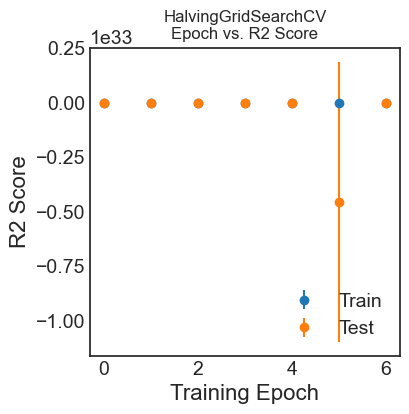

In [8]:
# display results of the gridsearch cv
cv_results = pd.DataFrame(grid_search.cv_results_)
display(cv_results.head())

# Plot mean and standard deviation of train and test error with training epoch
# Calculate mean and standard deviation of train and test scores for each epoch
mean_train_scores = cv_results.groupby('iter')['mean_train_score'].mean()
std_train_scores = cv_results.groupby('iter')['std_train_score'].mean()
mean_test_scores = cv_results.groupby('iter')['mean_test_score'].mean()
std_test_scores = cv_results.groupby('iter')['std_test_score'].mean()

plt.figure(figsize=(4, 4), dpi=100)
plt.errorbar(mean_train_scores.index, mean_train_scores, yerr=std_train_scores, label='Train', fmt='o')
plt.errorbar(mean_test_scores.index, mean_test_scores, yerr=std_test_scores, label='Test', fmt='o')
plt.xlabel('Training Epoch')
plt.ylabel('R2 Score')
plt.legend(loc='lower right')
plt.title('HalvingGridSearchCV\nEpoch vs. R2 Score')
plt.show()

Best Model Parameters


,alpha,l1_ratio
0,0.0001,0.08


Results on Test and Training Set


,Test,Train
RMSE,0.309630,0.283917
R^2,0.720791,0.749891
SMAPE,41.811727,41.573545


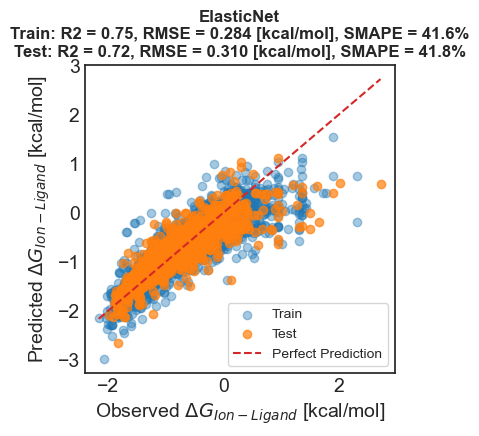

In [9]:
# Evaluate predictive accuracy on Test Set and Plot Results
print('Best Model Parameters')
display(pd.DataFrame(best_m_parameters, index=[0]))

results_df, fig = eval_model(best_m, X_train, X_test, y_train, y_test, parity_plot=True)

print('Results on Test and Training Set')
display(results_df)

### 3 - Evaluate model training with selected hyperparameters on ligand holdout AND ion holdout to determine new ligand and ion-specific error on the prediction.

- For LIGAND HOLDOUT: using the optimal hyperparameters as determined during model training, perform 10 iterations of:
    - Split ALL data available into train and test by withholding 10% of all the observed ligands from the dataset.
    - Train data on training ligands
    - Test data on withheld ligands.
    - Average the R2, RMSE, SMAPE across all iterations. Use Mean RMSE as error metric for a NEW ligand.
- For ION HOLDOUT: using the optimal hyperparameters as determined during model training, perform one iteration of the following for each ion in the dataset observations:
    - Split ALL data available into trian and test by witholding 50% of all datapoints in the training data for each ion (does not distinguish between ligands -- could this be data leakage?).
    - Train data on training set.
    - Test data on withheld, ion-specific datapoints.
    - Average the R2, RMSE, SMAPE across all iterations. Use Mean RMSE as error metric for ion-specific error on an OBSERVED ligand but an unobserved ion.

In [10]:
# Using best model parameters, perform ligand specific holdout and model evaluation

# Set up data holder
df_lhr = pd.DataFrame()

# specify experiment parameters
n_repeats = 10
ligand_holdout_ratio = 0.1 # X*100% of ligands held out for testing in each repeat
rnd_states = np.arange(n_repeats)
rnd_states = rnd_states + 42

# Perform ligand specific holdout with model evaluation
for ii, rnd in enumerate(rnd_states):
    print(f'Iteration: {ii + 1}/{n_repeats}')
    # split data into training and test set with ligand specific holdout
    train_ligands, test_ligands  = train_test_split(ligands,
                                                   test_size=ligand_holdout_ratio,
                                                   random_state=rnd, shuffle=True)
    test_indices = df[df['smiles'].isin(test_ligands)].index
    train_indices = df[df['smiles'].isin(train_ligands)].index

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    # train model with optimal hyperparameters
    optimal_m = ElasticNet(**best_m_parameters)
    optimal_m.fit(X_train, y_train)

    # evaluate model
    results_df, fig = eval_model(optimal_m, X_train, X_test, y_train, y_test, parity_plot=False)

    # store results in df_lhr
    df_lhr.loc[ii, 'Iteration'] = ii + 1
    df_lhr.loc[ii, 'Train Ligands'] = str(train_ligands)
    df_lhr.loc[ii, 'Test Ligands'] = str(test_ligands)
    df_lhr.loc[ii, 'n Train Ligands'] = len(train_ligands)
    df_lhr.loc[ii, 'n Test Ligands'] = len(test_ligands)
    df_lhr.loc[ii, 'n Train Datapoints'] = len(y_train)
    df_lhr.loc[ii, 'n Test Datapoints'] = len(y_test)
    df_lhr.loc[ii, 'Train RMSE'] = results_df.loc['RMSE', 'Train']
    df_lhr.loc[ii, 'Train R2'] = results_df.loc['R^2', 'Train']
    df_lhr.loc[ii, 'Train SMAPE'] = results_df.loc['SMAPE', 'Train']
    df_lhr.loc[ii, 'Test RMSE'] = results_df.loc['RMSE', 'Test']
    df_lhr.loc[ii, 'Test R2'] = results_df.loc['R^2', 'Test']
    df_lhr.loc[ii, 'Test SMAPE'] = results_df.loc['SMAPE', 'Test']

Iteration: 1/10


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.596e+02, tolerance: 2.114e-01
  model = cd_fast.enet_coordinate_descent(


Iteration: 2/10


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.508e+02, tolerance: 2.130e-01
  model = cd_fast.enet_coordinate_descent(


Iteration: 3/10


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.491e+02, tolerance: 2.070e-01
  model = cd_fast.enet_coordinate_descent(


Iteration: 4/10


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.455e+02, tolerance: 2.075e-01
  model = cd_fast.enet_coordinate_descent(


Iteration: 5/10


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.535e+02, tolerance: 2.084e-01
  model = cd_fast.enet_coordinate_descent(


Iteration: 6/10


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.545e+02, tolerance: 2.063e-01
  model = cd_fast.enet_coordinate_descent(


Iteration: 7/10


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.603e+02, tolerance: 2.065e-01
  model = cd_fast.enet_coordinate_descent(


Iteration: 8/10


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.736e+02, tolerance: 2.107e-01
  model = cd_fast.enet_coordinate_descent(


Iteration: 9/10


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.620e+02, tolerance: 2.072e-01
  model = cd_fast.enet_coordinate_descent(


Iteration: 10/10


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.554e+02, tolerance: 2.081e-01
  model = cd_fast.enet_coordinate_descent(


In [11]:
print("Summary of Ligand Holdout Results")
df_lhr_summary = df_lhr.describe()
display(df_lhr_summary)
print(f"Unobserved ligand prediction RMSE: {df_lhr_summary.loc['mean', 'Test RMSE']:.3f} [kcal/mol]")
display(df_lhr.head())

Summary of Ligand Holdout Results


,Iteration,n Train Ligands,n Test Ligands,n Train Datapoints,n Test Datapoints,Train RMSE,Train R2,Train SMAPE,Test RMSE,Test R2,Test SMAPE
count,10.00000,10.0,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,981.0,110.0,6291.500000,715.500000,0.282979,0.758413,41.618525,0.448052,0.219175,48.539606
std,3.02765,0.0,0.0,63.556187,63.556187,0.003885,0.007687,0.656449,0.131790,0.472937,5.248675
min,1.00000,981.0,110.0,6204.000000,615.000000,0.278367,0.744272,40.660375,0.316557,-0.629641,41.742951
25%,3.25000,981.0,110.0,6246.750000,670.750000,0.279762,0.753534,41.075213,0.362764,-0.159087,44.981644
50%,5.50000,981.0,110.0,6289.000000,718.000000,0.282479,0.758729,41.680628,0.393161,0.411606,48.535206
75%,7.75000,981.0,110.0,6336.250000,760.250000,0.284926,0.762808,42.199231,0.571011,0.556568,50.334082
max,10.00000,981.0,110.0,6392.000000,803.000000,0.290363,0.769022,42.370122,0.647994,0.652805,56.971254


Unobserved ligand prediction RMSE: 0.448 [kcal/mol]


,Iteration,Train Ligands,Test Ligands,n Train Ligands,n Test Ligands,n Train Datapoints,n Test Datapoints,Train RMSE,Train R2,Train SMAPE,Test RMSE,Test R2,Test SMAPE
0,1.0,"['O=C(NO)c1ccccc1O', 'Nc1ncnc2c1ncn2[C@@H]1O[C...","['O=Cc1cccc(Cl)c1O', 'O=C(O)c1cccc(Cl)c1C(=O)O...",981.0,110.0,6373.0,634.0,0.282608,0.759202,41.560061,0.410051,0.386056,48.311535
1,2.0,"['CCNCCNCCNCC', 'NN(CC(=O)O)CC(=O)O', 'O=c1cco...","['O=C(O)c1cccc(F)c1', 'N[C@@H](CS)C(=O)O', 'CN...",981.0,110.0,6349.0,658.0,0.278367,0.769022,40.716119,0.624664,-0.629641,50.855871
2,3.0,"['[Cl-]', 'CC(=O)N(O)c1ccc(C)cc1', 'c1ccc(-c2c...","['CC[C@H](C)[C@H](N)C(=O)NCC(=O)O', 'Nc1ccccc1...",981.0,110.0,6287.0,720.0,0.279107,0.763349,41.731130,0.628627,-0.340801,48.758878
3,4.0,"['CC(C)(N)C(=O)NC(C)(C)C(=O)NC(C)(C)C(=O)O', '...","['N[C@@H](CO)C(=O)O', 'CC(=O)c1c(C)cc(C)nc1C',...",981.0,110.0,6204.0,803.0,0.278613,0.767901,41.630127,0.392180,0.420108,46.825252
4,5.0,['CC(C)C[C@H](NC(=O)[C@@H](N)Cc1ccccc1)C(=O)O'...,"['C1COCCOCCNCCOCCOCCN1', 'CN(CP(=O)(O)O)CP(=O)...",981.0,110.0,6243.0,764.0,0.282351,0.761184,40.913598,0.387929,0.428206,56.971254


In [12]:
# Using the best model parameters, perform ION specific holdout and model evaluation.

breaking = False

# set up data holder
df_ihr = pd.DataFrame()

# specify experiment parameters
ion_dpoint_holdout_ratio = 0.5
rnd_states = np.arange(len(ephiles))
rnd_states = rnd_states + 42
n_ion_holdout_folds = 3

figures = []

# perform ion specific holdout with model evaluation
for ii, e in enumerate(ephiles):
    print(f'{e} Iteration: {ii + 1}/{len(ephiles)}')

    # perform n repeats for each ion
    # split data into training and test set with ion specific datapoint holdout
    for fold in range(n_ion_holdout_folds):
        print(f'Fold: {fold + 1}/{n_ion_holdout_folds}')
        
        # Split the ion-specific datapoints into training and test set
        test_indices = df[df['Electrophile'] == e].sample(frac=ion_dpoint_holdout_ratio, random_state=rnd_states[ii] + fold).index
        train_indices = df.drop(test_indices).index
        
        # Check for ligands that appear in both training and test indices
        # If ligands do appear in both, split them up and move the associated datapoints to either the training or test set to avoid
        # data leakage
        train_ligands_set = set(df.loc[train_indices, 'smiles'])
        test_ligands_set = set(df.loc[test_indices, 'smiles'])
        common_ligands = train_ligands_set.intersection(test_ligands_set)
        train_only_ligands = train_ligands_set.difference(test_ligands_set)
        test_only_ligands = test_ligands_set.difference(train_ligands_set)

        if len(common_ligands) > 0:
            df_e = df[df['Electrophile'] == e]
            common_ligands = list(common_ligands)

            move_to_train_ligands, move_to_test_ligands = train_test_split(common_ligands, test_size=0.5, random_state=rnd_states[ii] + fold)

            move_to_train_indices = df_e[df_e['smiles'].isin(move_to_train_ligands)].index
            move_to_test_indices = df_e[df_e['smiles'].isin(move_to_test_ligands)].index

            test_indices = test_indices.append(move_to_test_indices)
            test_indices = test_indices.drop(move_to_train_indices, errors='ignore')
            train_indices = train_indices.append(move_to_train_indices)
            train_indices = train_indices.drop(move_to_test_indices, errors='ignore')

        # Check if the split is valid
        df_e = df[df['Electrophile'] == e]
        e_train_indices = list(set(df_e.index).difference(test_indices))

        train_ligands = df_e.loc[e_train_indices]['smiles'].unique()
        test_ligands = df_e.loc[test_indices]['smiles'].unique()

        # if breaking:
        #     break

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        # Train model with optimal hyperparameters
        optimal_m = ElasticNet(**best_m_parameters)
        optimal_m.fit(X_train, y_train)

        # Evaluate model
        results_df, fig = eval_model(optimal_m, X_train, X_test, y_train, y_test, parity_plot=False)
        #figures.append((e, fig))
        #plt.close(fig)

        # Store results in df_ihr
        df_ihr.loc[ii * n_ion_holdout_folds + fold, 'Iteration'] = ii + 1
        df_ihr.loc[ii * n_ion_holdout_folds + fold, 'Fold'] = fold + 1
        df_ihr.loc[ii * n_ion_holdout_folds + fold, 'Ion'] = e
        df_ihr.loc[ii * n_ion_holdout_folds + fold, 'n Train Datapoints'] = len(y_train)
        df_ihr.loc[ii * n_ion_holdout_folds + fold, 'n Test Datapoints'] = len(y_test)
        df_ihr.loc[ii * n_ion_holdout_folds + fold, 'Train RMSE'] = results_df.loc['RMSE', 'Train']
        df_ihr.loc[ii * n_ion_holdout_folds + fold, 'Train R2'] = results_df.loc['R^2', 'Train']
        df_ihr.loc[ii * n_ion_holdout_folds + fold, 'Train SMAPE'] = results_df.loc['SMAPE', 'Train']
        df_ihr.loc[ii * n_ion_holdout_folds + fold, 'Test RMSE'] = results_df.loc['RMSE', 'Test']
        df_ihr.loc[ii * n_ion_holdout_folds + fold, 'Test R2'] = results_df.loc['R^2', 'Test']
        df_ihr.loc[ii * n_ion_holdout_folds + fold, 'Test SMAPE'] = results_df.loc['SMAPE', 'Test']
    
    if breaking:
            break
    

Mg2+ Iteration: 1/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.887e+02, tolerance: 2.256e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.913e+02, tolerance: 2.257e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.902e+02, tolerance: 2.271e-01
  model = cd_fast.enet_coordinate_descent(


Ca2+ Iteration: 2/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.840e+02, tolerance: 2.237e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.880e+02, tolerance: 2.254e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.789e+02, tolerance: 2.226e-01
  model = cd_fast.enet_coordinate_descent(


Sr2+ Iteration: 3/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.914e+02, tolerance: 2.275e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.907e+02, tolerance: 2.268e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.921e+02, tolerance: 2.274e-01
  model = cd_fast.enet_coordinate_descent(


La3+ Iteration: 4/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.921e+02, tolerance: 2.271e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.935e+02, tolerance: 2.284e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.936e+02, tolerance: 2.278e-01
  model = cd_fast.enet_coordinate_descent(


Pr3+ Iteration: 5/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.936e+02, tolerance: 2.278e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.928e+02, tolerance: 2.280e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.937e+02, tolerance: 2.275e-01
  model = cd_fast.enet_coordinate_descent(


Nd3+ Iteration: 6/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.933e+02, tolerance: 2.280e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.931e+02, tolerance: 2.275e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.930e+02, tolerance: 2.283e-01
  model = cd_fast.enet_coordinate_descent(


Sm3+ Iteration: 7/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.915e+02, tolerance: 2.271e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.943e+02, tolerance: 2.286e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.935e+02, tolerance: 2.280e-01
  model = cd_fast.enet_coordinate_descent(


Gd3+ Iteration: 8/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.937e+02, tolerance: 2.282e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.928e+02, tolerance: 2.279e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.934e+02, tolerance: 2.277e-01
  model = cd_fast.enet_coordinate_descent(


Tb3+ Iteration: 9/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.926e+02, tolerance: 2.278e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.935e+02, tolerance: 2.286e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.934e+02, tolerance: 2.284e-01
  model = cd_fast.enet_coordinate_descent(


Dy3+ Iteration: 10/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.928e+02, tolerance: 2.279e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.937e+02, tolerance: 2.285e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.935e+02, tolerance: 2.278e-01
  model = cd_fast.enet_coordinate_descent(


Er3+ Iteration: 11/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.928e+02, tolerance: 2.279e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.933e+02, tolerance: 2.280e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.925e+02, tolerance: 2.274e-01
  model = cd_fast.enet_coordinate_descent(


Mn2+ Iteration: 12/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.911e+02, tolerance: 2.263e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.882e+02, tolerance: 2.254e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.892e+02, tolerance: 2.258e-01
  model = cd_fast.enet_coordinate_descent(


Co2+ Iteration: 13/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.861e+02, tolerance: 2.239e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.859e+02, tolerance: 2.243e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.874e+02, tolerance: 2.244e-01
  model = cd_fast.enet_coordinate_descent(


Ni2+ Iteration: 14/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.788e+02, tolerance: 2.203e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.786e+02, tolerance: 2.224e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.820e+02, tolerance: 2.233e-01
  model = cd_fast.enet_coordinate_descent(


Cu2+ Iteration: 15/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.802e+02, tolerance: 2.160e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.820e+02, tolerance: 2.163e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.761e+02, tolerance: 2.173e-01
  model = cd_fast.enet_coordinate_descent(


Al3+ Iteration: 16/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.926e+02, tolerance: 2.277e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.922e+02, tolerance: 2.281e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.929e+02, tolerance: 2.276e-01
  model = cd_fast.enet_coordinate_descent(


Zn2+ Iteration: 17/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.834e+02, tolerance: 2.223e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.839e+02, tolerance: 2.221e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.810e+02, tolerance: 2.223e-01
  model = cd_fast.enet_coordinate_descent(


Na+ Iteration: 18/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.915e+02, tolerance: 2.266e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.895e+02, tolerance: 2.261e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.908e+02, tolerance: 2.259e-01
  model = cd_fast.enet_coordinate_descent(


Fe3+ Iteration: 19/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.894e+02, tolerance: 2.249e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.926e+02, tolerance: 2.262e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.880e+02, tolerance: 2.245e-01
  model = cd_fast.enet_coordinate_descent(


Li+ Iteration: 20/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.931e+02, tolerance: 2.273e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.933e+02, tolerance: 2.274e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.927e+02, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


K+ Iteration: 21/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.925e+02, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.927e+02, tolerance: 2.262e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.910e+02, tolerance: 2.261e-01
  model = cd_fast.enet_coordinate_descent(


Rb+ Iteration: 22/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.936e+02, tolerance: 2.281e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.936e+02, tolerance: 2.283e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.927e+02, tolerance: 2.279e-01
  model = cd_fast.enet_coordinate_descent(


Cs+ Iteration: 23/23
Fold: 1/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.943e+02, tolerance: 2.286e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 2/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.935e+02, tolerance: 2.285e-01
  model = cd_fast.enet_coordinate_descent(


Fold: 3/3


/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.932e+02, tolerance: 2.283e-01
  model = cd_fast.enet_coordinate_descent(


In [13]:
df_ihr_summary = pd.DataFrame()

for ii, e in enumerate(ephiles):
    df_ihr_summary.loc[ii, 'Ion'] = e
    df_ihr_summary.loc[ii, 'n_folds'] = df_ihr[df_ihr['Ion'] == e].shape[0]
    df_ihr_summary.loc[ii, 'Mean Train Datapoints'] = df_ihr[df_ihr['Ion'] == e]['n Train Datapoints'].mean()
    df_ihr_summary.loc[ii, 'Std Train Datapoints'] = df_ihr[df_ihr['Ion'] == e]['n Train Datapoints'].std()
    df_ihr_summary.loc[ii, 'Mean Test Datapoints'] = df_ihr[df_ihr['Ion'] == e]['n Test Datapoints'].mean()
    df_ihr_summary.loc[ii, 'Std Test Datapoints'] = df_ihr[df_ihr['Ion'] == e]['n Test Datapoints'].std()
    df_ihr_summary.loc[ii, 'Mean Test RMSE'] = df_ihr[df_ihr['Ion'] == e]['Test RMSE'].mean()
    df_ihr_summary.loc[ii, 'Std Test RMSE'] = df_ihr[df_ihr['Ion'] == e]['Test RMSE'].std()
    df_ihr_summary.loc[ii, 'Mean Test R2'] = df_ihr[df_ihr['Ion'] == e]['Test R2'].mean()
    df_ihr_summary.loc[ii, 'Std Test R2'] = df_ihr[df_ihr['Ion'] == e]['Test R2'].std()
    df_ihr_summary.loc[ii, 'Mean Test SMAPE'] = df_ihr[df_ihr['Ion'] == e]['Test SMAPE'].mean()
    df_ihr_summary.loc[ii, 'Std Test SMAPE'] = df_ihr[df_ihr['Ion'] == e]['Test SMAPE'].std()
    df_ihr_summary.loc[ii, 'Mean Train RMSE'] = df_ihr[df_ihr['Ion'] == e]['Train RMSE'].mean()
    df_ihr_summary.loc[ii, 'Std Train RMSE'] = df_ihr[df_ihr['Ion'] == e]['Train RMSE'].std()
    df_ihr_summary.loc[ii, 'Mean Train R2'] = df_ihr[df_ihr['Ion'] == e]['Train R2'].mean()
    df_ihr_summary.loc[ii, 'Std Train R2'] = df_ihr[df_ihr['Ion'] == e]['Train R2'].std()
    df_ihr_summary.loc[ii, 'Mean Train SMAPE'] = df_ihr[df_ihr['Ion'] == e]['Train SMAPE'].mean()
    df_ihr_summary.loc[ii, 'Std Train SMAPE'] = df_ihr[df_ihr['Ion'] == e]['Train SMAPE'].std()

# Create and print a dictionary mapping ion identity onto mean test RMSE
ion_to_mean_test_rmse = df_ihr.groupby('Ion')['Test RMSE'].mean().round(3).to_dict()
ion_to_mean_test_rmse = pd.DataFrame(ion_to_mean_test_rmse, index=['Mean Prediction RMSE [kcal/mol]']).transpose()
display(ion_to_mean_test_rmse)

display(df_ihr_summary)

,Mean Prediction RMSE [kcal/mol]
Al3+,0.309
Ca2+,0.430
Co2+,0.305
Cs+,0.378
Cu2+,0.292
Dy3+,0.199
Er3+,0.225
Fe3+,0.361
Gd3+,0.193
K+,0.417


,Ion,n_folds,Mean Train Datapoints,Std Train Datapoints,Mean Test Datapoints,Std Test Datapoints,Mean Test RMSE,Std Test RMSE,Mean Test R2,Std Test R2,Mean Test SMAPE,Std Test SMAPE,Mean Train RMSE,Std Train RMSE,Mean Train R2,Std Train R2,Mean Train SMAPE,Std Train SMAPE
0,Mg2+,3.0,6923.666667,8.504901,211.000000,9.539392,0.297094,0.020391,0.630072,0.085101,50.162689,5.875804,0.287190,0.000473,0.747437,0.001382,41.607170,0.179203
1,Ca2+,3.0,6887.666667,11.718931,272.666667,14.224392,0.429933,0.068196,0.445164,0.065172,72.289845,5.618134,0.284603,0.002592,0.750845,0.002691,41.109991,0.299067
2,Sr2+,3.0,6961.666667,3.511885,102.333333,5.507571,0.333559,0.051718,0.587886,0.127962,70.215528,11.737232,0.287055,0.000395,0.747531,0.000386,41.460990,0.156414
3,La3+,3.0,6956.666667,4.725816,126.333333,4.725816,0.214663,0.048454,0.781668,0.056108,29.340791,3.850304,0.287979,0.000400,0.746690,0.000359,41.779268,0.088769
4,Pr3+,3.0,6967.666667,5.131601,90.333333,1.527525,0.175780,0.050960,0.859843,0.084811,18.110739,1.678677,0.287917,0.000289,0.746375,0.000692,41.813331,0.053462
5,Nd3+,3.0,6962.333333,4.041452,95.333333,3.055050,0.195811,0.007603,0.755252,0.101761,24.713800,1.052192,0.287905,0.000047,0.746841,0.000522,41.773431,0.021075
6,Sm3+,3.0,6963.666667,1.527525,108.333333,0.577350,0.208153,0.070954,0.764295,0.061879,22.291918,4.428852,0.287862,0.000665,0.746816,0.000432,41.814700,0.110359
7,Gd3+,3.0,6970.000000,4.000000,96.666667,4.163332,0.193213,0.057243,0.807340,0.075012,19.507833,3.016667,0.287826,0.000299,0.746683,0.000386,41.814860,0.030839
8,Tb3+,3.0,6972.333333,4.932883,81.333333,4.725816,0.226829,0.063407,0.752928,0.053732,28.820327,6.522519,0.287708,0.000375,0.747131,0.000088,41.744732,0.081901
9,Dy3+,3.0,6970.666667,10.263203,85.000000,10.583005,0.199404,0.050446,0.812683,0.048409,24.357135,3.425411,0.287825,0.000422,0.746784,0.000414,41.780001,0.089928


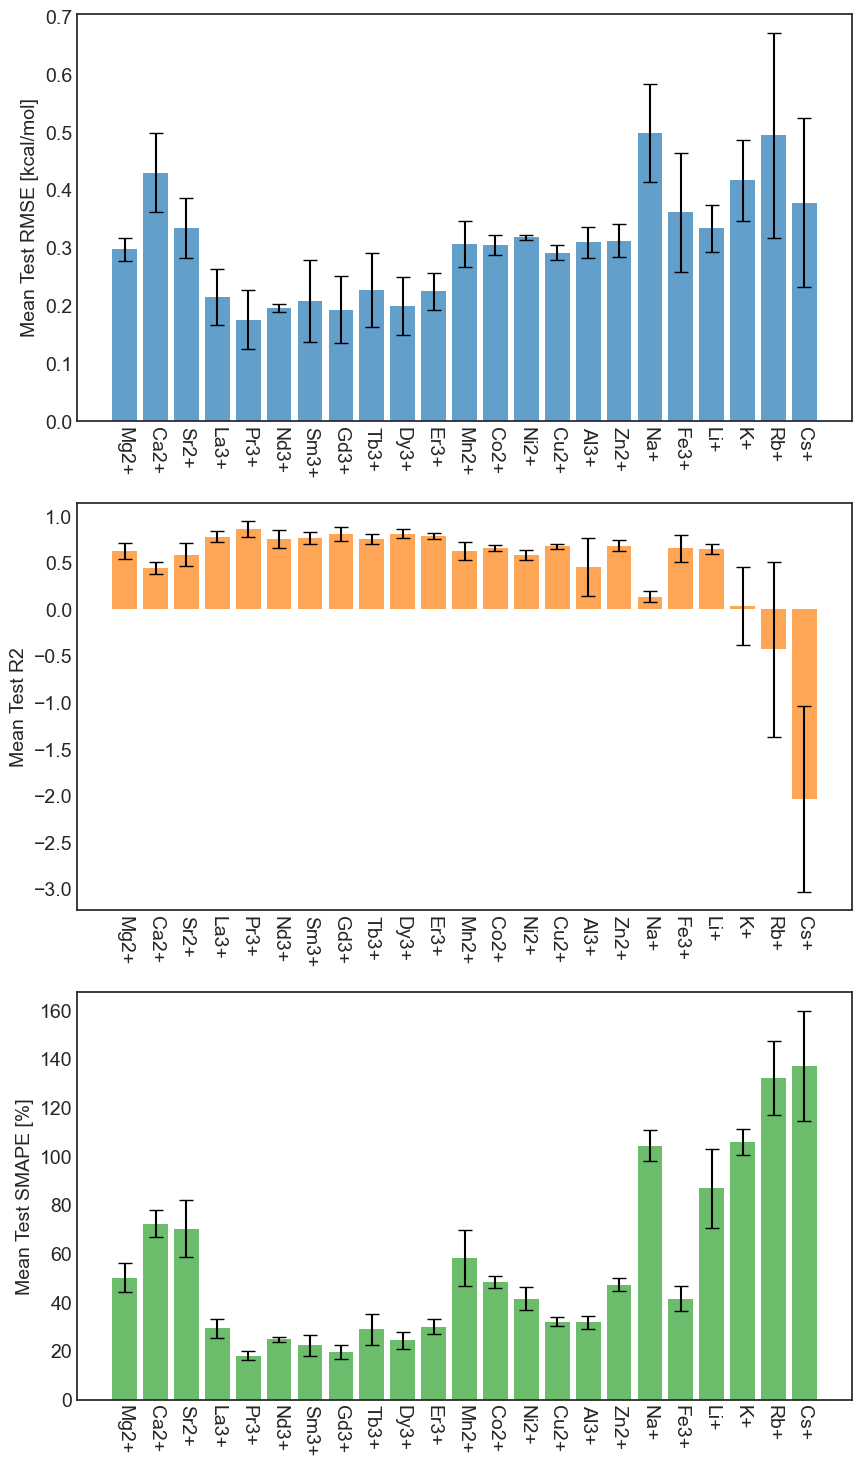

In [14]:
fig, axs = plt.subplots(3,1, figsize=(10, 18), dpi=100)

# plot RMSE
axs[0].bar(df_ihr_summary['Ion'], df_ihr_summary['Mean Test RMSE'],
           yerr=df_ihr_summary['Std Test RMSE'], color='tab:blue', alpha=0.7, capsize=5)
axs[0].set_ylabel('Mean Test RMSE [kcal/mol]', fontsize=14)

# plot R2
axs[1].bar(df_ihr_summary['Ion'], df_ihr_summary['Mean Test R2'],
           yerr=df_ihr_summary['Std Test R2'], color='tab:orange', alpha=0.7, capsize=5)
axs[1].set_ylabel('Mean Test R2', fontsize=14)

# plot SMAPE
axs[2].bar(df_ihr_summary['Ion'], df_ihr_summary['Mean Test SMAPE'],
           yerr=df_ihr_summary['Std Test SMAPE'], color='tab:green', alpha=0.7, capsize=5)
axs[2].set_ylabel('Mean Test SMAPE [%]', fontsize=14)

for i in range(len(axs)):
    axs[i].tick_params(axis='x', rotation=-90)

In [15]:
# create the error dataframe to save for future use.

error_df = pd.DataFrame()
error_df['Error Category'] = df_ihr_summary['Ion']
error_df['RMSE [kcal/mol]'] = df_ihr_summary['Mean Test RMSE']

unobserved_ligand_df = pd.DataFrame()
unobserved_ligand_df['Error Category'] = ['Unobserved Ligand']
unobserved_ligand_df['RMSE [kcal/mol]'] = df_lhr_summary.loc['mean', 'Test RMSE']

error_df = pd.concat([error_df, unobserved_ligand_df], ignore_index=True)
display(error_df)

,Error Category,RMSE [kcal/mol]
0,Mg2+,0.297094
1,Ca2+,0.429933
2,Sr2+,0.333559
3,La3+,0.214663
4,Pr3+,0.175780
5,Nd3+,0.195811
6,Sm3+,0.208153
7,Gd3+,0.193213
8,Tb3+,0.226829
9,Dy3+,0.199404


### 4 - Train Model on ALL available data and save model for future use in dGTool and dGScreen, also noting the reported RMSE error on prediction, for use later in fitting LFERs.

In [ ]:
save_model_and_error = False

dir_path = '../Outputs/Fitted Models/'
model_name = f'ElasticNet_HalvingGridSearchCV_{datetime.now().strftime("%Y%m%d_%H%M%S")}'

# Check if directory exists, if not, create it
if save_model_and_error:
    full_path = os.path.join(dir_path, model_name)
    if not os.path.exists(full_path):
        os.makedirs(full_path)

/Users/wyliekau/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.941e+02, tolerance: 2.288e-01
  model = cd_fast.enet_coordinate_descent(


,Test,Train
RMSE,0.287450,0.287450
R^2,0.746943,0.746943
SMAPE,41.683460,41.683460


/var/folders/51/1469qh3n09s2ntzgsg9vcfzc0000gn/T/ipykernel_75341/1887085974.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Normalized Importance', y='Feature', data=top_20_features, palette='viridis', ax=axs2)


Model, importance, and error saved to ../Outputs/Fitted Models/ElasticNet_HalvingGridSearchCV_20250313_162809


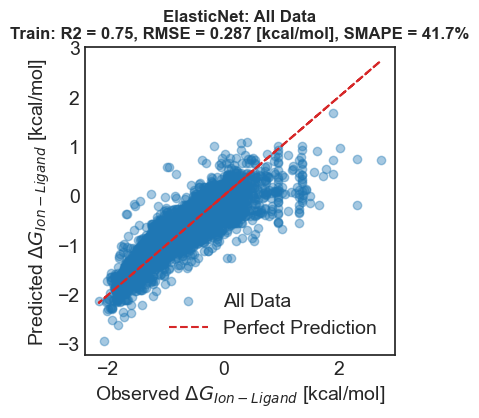

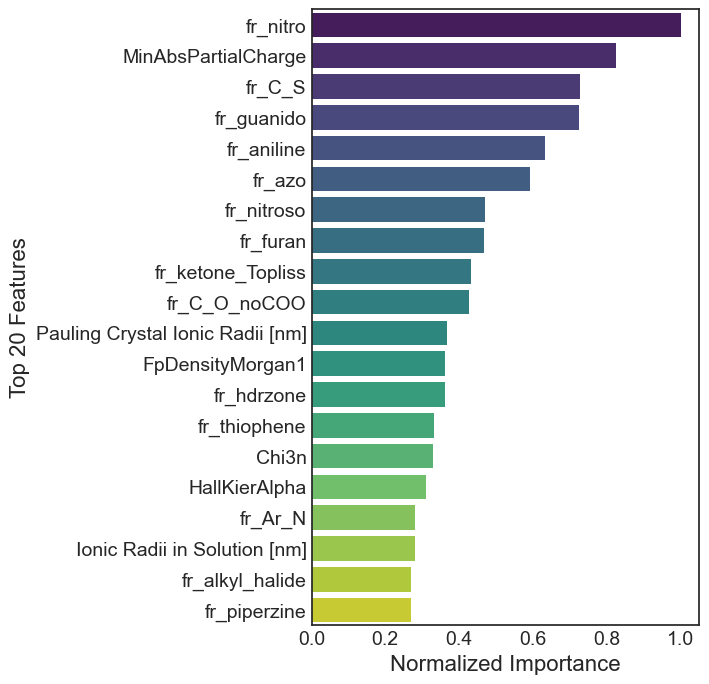

In [17]:
m_all_train = ElasticNet(**best_m_parameters)
m_all_train.fit(X, y)

results_df, fig = eval_model(m_all_train, X, X, y, y, parity_plot=False)
display(results_df)

fig, axs = plt.subplots(1, figsize=(4,4), dpi=100)
axs.scatter(y, m_all_train.predict(X), color='tab:blue', alpha=0.4, label='All Data')
axs.plot(y, y, ls='--', color='tab:red', alpha=1.0, label='Perfect Prediction')
axs.set_xlabel(r'Observed $\Delta G_{Ion-Ligand}$ [kcal/mol]', fontsize=14)
axs.set_ylabel(r'Predicted $\Delta G_{Ion-Ligand}$ [kcal/mol]', fontsize=14)
axs.legend()
model_class = m_all_train.__class__.__name__
axs.set_title(f'{model_class}: All Data\nTrain: R2 = {results_df.loc["R^2", "Train"]:.2f}, RMSE = {results_df.loc["RMSE", "Train"]:.3f} [kcal/mol], SMAPE = {results_df.loc["SMAPE", "Train"]:.1f}%',fontweight='bold')

# Plot feature importances
importances = m_all_train.coef_
norm_importances = importances / np.max(importances)

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Normalized Importance': norm_importances,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Normalized Importance', ascending=False)

# Select top 20 features
top_20_features = feature_importance_df.head(20)

# Plot the feature importances
fig2, axs2 = plt.subplots(1, figsize=(5, 8), dpi=100)
sns.barplot(x='Normalized Importance', y='Feature', data=top_20_features, palette='viridis', ax=axs2)
axs2.set_ylabel('Top 20 Features')

if save_model_and_error:
    model_save_path = os.path.join(full_path, 'model.pkl')
    error_df_save_path = os.path.join(full_path, 'error_df.csv')
    feature_importance_save_path = os.path.join(full_path, 'feature_importance.csv')

    # Check if files already exist
    if os.path.exists(model_save_path) or os.path.exists(error_df_save_path) and os.path.exists(feature_importance_save_path):
        print(f"Files already exist. Aborting save operation.")
    else:
        # Save the model and error dataframe and feature importance dataframe
        with open(model_save_path, 'wb') as f:
            pickle.dump(m_all_train, f)

        error_df.to_csv(error_df_save_path, index=False)
        feature_importance_df.to_csv(feature_importance_save_path, index=False)

        # save figures
        fig.savefig(os.path.join(full_path, 'parity_plot.png'), dpi=300, bbox_inches='tight')
        fig2.savefig(os.path.join(full_path, 'feature_importance.png'), dpi=300, bbox_inches='tight')

        print(f"Model, importance, and error saved to {full_path}")
